## Summary 

In [1]:
import glob, os
import sys

import subprocess
import numpy as np

import pandas as pd
from pandas import ExcelFile 

from matplotlib import *
from matplotlib import cm
import matplotlib.ticker
import  pylab as plt
import seaborn
import seaborn as sns

#import ipywidgets as widgets

from scipy import stats

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import EState
from rdkit.Chem import MolDb
from rdkit.Chem import QED
from rdkit.Chem import rdchem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import MDAnalysis as mda
from MDAnalysis.lib.formats.libdcd import DCDFile
from MDAnalysis.analysis import contacts,align,rms
from MDAnalysis.analysis.base import AnalysisFromFunction
from MDAnalysis.coordinates.memory import MemoryReader

from sklearn import linear_model
from sklearn import preprocessing


import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

from Scripts.IFP_generation import *
from Scripts.Trajectories import *
from Scripts.Clustering import *
from Scripts.Complex_structure import *

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.cluster import KMeans

from kmodes.kmodes import KModes
import nglview as nv

_ColormakerRegistry()

In [2]:
########################################
#
#     PLOT tauRAMD evaluation for a set of compounds with available exp.data
#
########################################
def PLOT_tauRAMD_dataset(tr,tr_name = None,types_list = [""]):
    """
    Parameters:
    tr_FAK_- a set of trajectory objects (for each ligand)
    tr_FAK_name - name of the ligand to be indicated in the plot
    types_list - a list of ligand types to be shown in different colors
    Returns:
    """
    fig = plt.figure(figsize=(16, 8))
    color = ['r','b','green','m','c','orange','yellow','goldenrod','olive','tomato','salmon','seagreen']
    #color =  cm.rainbow(np.logspace(0.1, 1, len(tr)))
    
    if tr_name:
        if (len(tr) != len(tr_name)): tr_name = None
            
    x_tick_lable = []
    x_tick_pos = []
    for k in range(0,5):
        for ii,i in enumerate(range(pow(10,k),pow(10,k+1),pow(10,k))):  
            if(ii == 0): x_tick_lable.append(str(i/10.))
            else: x_tick_lable.append("")
            x_tick_pos.append(np.log10(i/10.))
    y_tick_lable = []
    y_tick_pos = []
    
    for k in range(0,4):
        for ii,i in enumerate(range(pow(10,k),pow(10,k+1),pow(10,k))):            
            if(ii == 0): y_tick_lable.append(str(i/100.))
            else: y_tick_lable.append("")
            y_tick_pos.append(np.log10(i/100.))
            
            
    for i,type_comp in enumerate(types_list):        
        X = []
        y = []
        X_err = []
        y_err = []
        txt = []
        for j,t in enumerate(tr):
            if t.tau_exp and t.ramd.tau:
                if ((t.type == type_comp) or ( t.type == "")):
                    X.append(np.log10(t.ramd.tau))
                    y.append(t.tau_exp)
                    y_err.append(t.tau_exp_SD)
                    X_err.append(1/(t.ramd.tau*np.log(10))*t.ramd.tau_SD)
                    if tr_name:
                        txt.append(tr_name[j]) 
        ax = fig.add_subplot(111)
        plt.errorbar(x=y,y=X,xerr=y_err,yerr= X_err, color = "black" , fmt='o', markersize=1,lw=1 )
        plt.scatter(x=y,y=X, color = color[i] , s=100 )
        plt.xticks(x_tick_pos,x_tick_lable, fontsize=18)
        plt.yticks(y_tick_pos,y_tick_lable, fontsize=18)
        try:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x=y,y=X)
            fitt = np.asarray(y)*slope+intercept
            ind = np.argwhere(np.abs(fitt-X) < 0.5).flatten()
            slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.asarray(y)[ind],y=np.asarray(X)[ind])
            ind = np.argwhere(np.abs(fitt-X) >= 0.5).flatten()
            fitt = np.asarray(y)*slope+intercept
            if (len(ind) > 0):
                if tr_name: print("Outliers: ",np.asarray(txt)[ind])
                plt.scatter(x=np.asarray(y)[ind],y=np.asarray(X)[ind],color = 'orange',alpha=0.5,s=300)
            plt.plot(y,fitt,color = color[i],linewidth=1,linestyle='dotted')
        except:
            pass
        ax.set_xlabel(r'log($1/k_{off} $ [s])',fontsize=18)
        ax.set_ylabel(r'log($\tau_{RAMD} $ [s])',fontsize=18)
        plt.grid(True)
        if tr_name:
            for j, t in enumerate(txt): ax.annotate(t, (y[j], X[j]))
            print("R2 =",r_value)
    return



########################################
#
#     PLOT tauRAMD evaluation for a set of compounds with available exp.data
#
########################################
def PLOT_tauRAMD_2datasets(tr,tr_name,types_list,tr1,tr1_name ,types_list1 ):
    """
    Parameters:
    tr_FAK_- a set of trajectory objects (for each ligand)
    tr_FAK_name - name of the ligand to be indicated in the plot
    types_list - a list of ligand types to be shown in different colors
    Returns:
    """
    fig = plt.figure(figsize=(14,8))  # 14,8 or 9,5
    color = ['r','b','green','m','c','orange','yellow','goldenrod','olive','tomato','salmon','seagreen']
    #color =  cm.rainbow(np.logspace(0.1, 1, len(tr)))
    
    if tr_name:
        if (len(tr) != len(tr_name)): tr_name = None
            
    x_tick_lable = []
    x_tick_pos = []
    for k in range(0,5):
        for ii,i in enumerate(range(pow(10,k),pow(10,k+1),pow(10,k))):  
            if(ii == 0): x_tick_lable.append(str(i/10.))
            else: x_tick_lable.append("")
            x_tick_pos.append(np.log10(i/10.))
    y_tick_lable = []
    y_tick_pos = []
    
    for k in range(0,4):
        for ii,i in enumerate(range(pow(10,k),pow(10,k+1),pow(10,k))):            
            if(ii == 0): y_tick_lable.append(str(i/100.))
            else: y_tick_lable.append("")
            y_tick_pos.append(np.log10(i/100.))
    
    Xtot = []
    ytot = []
    
    ax = fig.add_subplot(111)        
    for i,type_comp in enumerate(types_list):        
        X = []
        y = []
        X_err = []
        y_err = []
        txt = []
        for j,(t,name) in enumerate(zip(tr,tr_name)):
            if t.tau_exp and t.ramd.tau:
                if ((t.type == type_comp) or ( t.type == "")):
                    X.append(np.log10(t.ramd.tau))
                    y.append(t.tau_exp)
                    Xtot.append(np.log10(t.ramd.tau))
                    ytot.append(t.tau_exp)
                    y_err.append(t.tau_exp_SD)
                    X_err.append(1/(t.ramd.tau*np.log(10))*t.ramd.tau_SD)
                    txt.append(name)        
        plt.errorbar(x=y,y=X,xerr=y_err,yerr= X_err, color = "black" , fmt='o', markersize=1,lw=1 )
        plt.scatter(x=y,y=X, color = color[i] , s=200 ,label="FAK")
        plt.xticks(x_tick_pos,x_tick_lable, fontsize=22)
        plt.yticks(y_tick_pos,y_tick_lable, fontsize=22)
        try:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x=y,y=X)
            fitt = np.asarray(y)*slope+intercept
            ind = np.argwhere(np.abs(fitt-X) < 0.6).flatten()
            slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.asarray(y)[ind],y=np.asarray(X)[ind])
            ind = np.argwhere(np.abs(fitt-X) >= 0.6).flatten()
            fitt = np.asarray(y)*slope+intercept
            if (len(ind) > 0):
                if tr_name: print("Outliers: ",np.asarray(txt)[ind])
                plt.scatter(x=np.asarray(y)[ind],y=np.asarray(X)[ind],color = 'orange',alpha=0.5,s=500)
#            plt.plot(y,fitt,color = color[i],linewidth=1,linestyle='dotted')
        except:
            pass
#        print("R2 =",r_value)
            
    for i,type_comp in enumerate(types_list1):        
        X = []
        y = []
        X_err = []
        y_err = []
        txt = []
        for j,t in enumerate(tr1):
            if t.tau_exp and t.ramd.tau:
                if ((t.type == type_comp) or ( t.type == "")):
                    X.append(np.log10(t.ramd.tau))
                    y.append(t.tau_exp)
                    Xtot.append(np.log10(t.ramd.tau))
                    ytot.append(t.tau_exp)
                    y_err.append(t.tau_exp_SD)
                    X_err.append(1/(t.ramd.tau*np.log(10))*t.ramd.tau_SD)
                    txt.append(tr1_name[j]) 
        ax.errorbar(x=y,y=X,xerr=y_err,yerr= X_err, color = "black" , fmt='o', markersize=1,lw=1 )
        ax.scatter(x=y,y=X, color = color[i+2] , s=200 ,label="PYK2")
#        for j, t in enumerate(txt):    ax.annotate(t, (y[j], X[j]), fontsize=16)

    ax.set_xlabel(r'$1/k_{off} $ [s]',fontsize=26,color= 'k')
    ax.set_ylabel(r'$\tau_{RAMD} $ [ns]',fontsize=26,color= 'k')
    plt.grid(True)
    plt.legend(fontsize=20)  
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=ytot,y=Xtot)
    fitt = np.asarray(ytot)*slope+intercept
    ind = np.argwhere(np.abs(fitt-Xtot) < 0.4).flatten()
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.asarray(ytot)[ind],y=np.asarray(Xtot)[ind])
    fitt = np.asarray(ytot)*slope+intercept
    plt.plot(ytot,fitt,color = 'k',linewidth=1,linestyle='dotted')
    ind = np.argwhere(np.abs(fitt-Xtot) >= 0.4).flatten()
    print("total R2 =",r_value)
    print(np.sqrt(np.mean((np.asarray(ytot)-(Xtot-intercept)/slope)*(np.asarray(ytot)-(Xtot-intercept)/slope))))
    print(np.abs((np.asarray(ytot)-(Xtot-intercept)/slope)))
    print(np.sqrt(np.mean((np.asarray(ytot)-np.asarray(fitt))*(np.asarray(Xtot)-np.asarray(fitt)))))
#    if (len(ind) > 0):
#        plt.scatter(x=np.asarray(ytot)[ind],y=np.asarray(Xtot)[ind],color = 'orange',alpha=0.5,s=500)
#        plt.plot(ytot,fitt,color = color[i],linewidth=1,linestyle='dotted')

    
#    plt.show()
    plt.savefig('RAMD.png',dpi=300)
    return

# 1. Analysis for all compounds of  FAK

In [3]:
ramd_trj = "*13_out/*dcd"

In [4]:
DIR_all = "/hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/"


exel = DIR_all+"RAMD-FAK-PYK-12-2019.xlsx"
if os.path.isfile(exel):
    try:
        exp_data = pd.read_excel(exel, sheet_name="Benni-paper" , skeepfooter = 5)
    except:
        print("cannot read ",exel)
else:
    print(exel, " was not found") 



In [5]:
exp_data

,Unnamed: 0,paper,filename,koff,kd,kon,koff_SD,kd_SD,kon_SD,type,resi,A-loop_conf,Unnamed: 12,Unnamed: 13,PDB,paper.1
0,1,PF271,2216855,0.003420,7.590000e-10,3500000.0,0.000783,0.000000e+00,0.000000e+00,2,D-Y-G-I,IN,PF271,NaN,3bz3,1.0
1,2,MSC487,No2364487_as_in_SMILES_new,0.066500,2.220000e-05,2990.0,0.010061,5.336841e-07,4.382071e+02,2,D-Y-G-I,NaN,NaN,NaN,NaN,2.0
2,3,MSC376,2362376,0.292000,3.290000e-07,881000.0,0.088049,0.000000e+00,2.384701e+05,1,Y-G-I,loop,NaN,NaN,not refined/model,3.0
3,4,MSC590,2394590,0.006220,7.060000e-08,87200.0,0.002300,0.000000e+00,6.500000e+05,2,D-Y-G-I,helix,2396008,NaN,Marta,NaN
4,5,MSC008,2396008,2.230000,9.860000e-06,227000.0,0.701000,0.000000e+00,0.000000e+00,2,D-Y-G-I,helix,2396008,NaN,Marta,NaN
5,6,PF228,2306349,0.008160,1.320000e-09,7200000.0,0.002200,0.000000e+00,0.000000e+00,1,D-Y-G-I,helix,2306349,NaN,x,6.0
6,7,MSC722,2396722,0.060900,3.650000e-08,1650000.0,0.045700,0.000000e+00,0.000000e+00,1,D-Y-G-I,loop,MSC072,NaN,model,7.0
7,8,MSC980,2393980,0.135000,1.000000e-06,142000.0,0.030606,2.254110e-07,4.442991e+04,2,D-Y-G-I,loop,MSC073,NaN,model,8.0
8,9,MSC072,2363072,0.071400,1.520000e-08,4790000.0,0.029806,2.576802e-09,1.981986e+06,1,D-Y-G-I,loop,MSC074,NaN,Marta,NaN
9,10,MSC979,2393979,0.047500,2.630000e-07,181000.0,0.013293,2.121370e-08,5.059509e+04,2,D-Y-G-I,loop,MSC075,NaN,model/docked,10.0


======================= 2216855 ===============================
Ligand properties:
Donor ['N9', 'N10', 'N25']
Acceptor ['N1', 'N2', 'N4', 'O26', 'O32', 'O33']
Aromatic ['N1', 'C19', 'C18', 'C17', 'C13', 'C20', 'N2', 'C3', 'N4', 'C5', 'C6', 'C7', 'C11', 'C14', 'C22', 'C21', 'C15', 'C16']
Hydrophobe ['C6', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C22', 'C23', 'C34', 'F27', 'F28', 'F29']
LumpedHydrophobe ['C11', 'C14', 'C22', 'C21', 'C15', 'C16']
6  Equilibration trajectories found
10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2216855/RAMD1
10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2216855/RAMD2
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2216855/RAMD3
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2216855/RAMD4
10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2216855/RAMD5

 0 None NAMD generated 6; RAMD generated 5  
RAMD1 tau= 3.23 +- 0.42 [2.277, 1.931, 3.664, 6.3340000000000005, 1.383, 


SKIP  38 /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2324090-E506I-loop RAMD data are missing; NAMD trajectories generated 4
======================= 18 ===============================
======================= 1orlz ===============================
======================= 2364487_as_in_SMILES_new ===============================
======================= 16 ===============================
======================= 2394590-PROT-conf2 ===============================
Ligand properties:
Donor ['N8', 'N25']
Acceptor ['N5', 'N10', 'N14', 'O29', 'O30']
Aromatic ['C1', 'C2', 'C3', 'C4', 'N5', 'C6', 'C9', 'N10', 'C11', 'C12', 'C13', 'N14', 'C19', 'C20', 'C21', 'C22', 'C24', 'C23']
Hydrophobe ['C1', 'C2', 'C3', 'C12', 'C19', 'C20', 'C22', 'C23', 'C24', 'C31', 'F16', 'F17', 'F18']
LumpedHydrophobe ['C19', 'C20', 'C21', 'C22', 'C24', 'C23']
6  Equilibration trajectories found
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2394590-PROT-conf2/RAMD1
10  RAMD traj. found in  /hits/fast/mcm/kokh

RDKit WARNING: [13:57:25] Cannot determine element for PDB atom #39


======================= 2306349 ===============================
Ligand properties:
Donor ['N12', 'N23', 'N33']
Acceptor ['O8', 'O9', 'N14', 'N16', 'O34']
Aromatic ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C13', 'N14', 'C15', 'N16', 'C17', 'C18', 'C24', 'C25', 'C29', 'C28', 'C26', 'C27']
Hydrophobe ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C10', 'C18', 'C25', 'C26', 'C27', 'C29', 'C30', 'C31', 'F20', 'F21', 'F22']
LumpedHydrophobe ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C24', 'C25', 'C29', 'C28', 'C26', 'C27']
8  Equilibration trajectories found
10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2306349/RAMD1
10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2306349/RAMD2
10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2306349/RAMD3
10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2306349/RAMD5

 56 None NAMD generated 8; RAMD generated 4  
RAMD1 tau= 0.889 +- 0.055 [0.878, 0.731, 0.9520000000000001, 0.6990000000000001, 2.66, 2.112, 0.

10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2324090/RAMD1
9  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2324090/RAMD2
10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2324090/RAMD3
10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2324090/RAMD4

 132 None NAMD generated 4; RAMD generated 4  
RAMD1 tau= 0.109 +- 0.005 [0.07, 0.112, 0.10300000000000001, 0.395, 0.124, 0.101, 0.052000000000000005, 0.184, 0.1, 0.122]
RAMD2 tau= 0.178 +- 0.023 [0.303, 0.195, 0.271, 0.123, 0.198, 0.117, 0.192, 0.14300000000000002, 0.085]
RAMD3 tau= 0.081 +- 0.007 [0.025, 0.024, 0.10400000000000001, 0.12, 0.121, 0.073, 0.075, 0.078, 0.109, 0.039]
RAMD4 tau= 0.108 +- 0.023 [0.064, 0.20500000000000002, 0.081, 0.045, 0.134, 0.039, 0.065, 0.217, 0.23600000000000002, 0.14300000000000002]
======================= 2396722 ===============================
Ligand properties:
Donor ['N', 'N27', 'N29']
Acceptor ['N10', 'N14', 'O28']
Aromatic ['C', 'C3', 


SKIP  162 /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2324090-E506I RAMD data are missing; NAMD trajectories generated 4
======================= 2393979-A-loop-L1 ===============================
======================= 30 ===============================
======================= 1atat-pqr ===============================
======================= 1wlsg-charged ===============================
======================= 2396008 ===============================
Ligand properties:
Donor ['N7', 'N25', 'N32']
Acceptor ['N1', 'N3', 'N17', 'O22', 'O23', 'O36']
Aromatic ['N1', 'C2', 'N3', 'C4', 'C5', 'C6', 'C13', 'C14', 'C15', 'C16', 'N17', 'C18', 'C26', 'C27', 'C28', 'C31', 'C30', 'C29']
Hydrophobe ['C5', 'C13', 'C14', 'C15', 'C24', 'C27', 'C28', 'C29', 'C30', 'C34', 'C35', 'F10', 'F11', 'F9']
LumpedHydrophobe ['C26', 'C27', 'C28', 'C31', 'C30', 'C29']
5  Equilibration trajectories found
10  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2396008/RAMD1
10  RAMD traj. found in  /hits/fast/mcm/

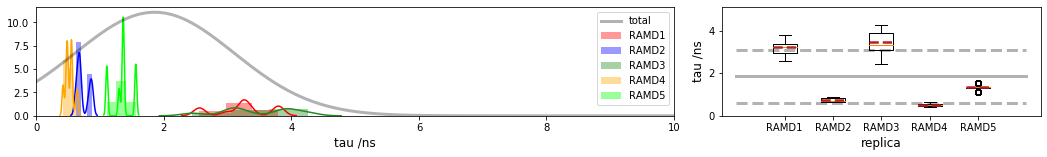

2363072 :  tauRAMD=  0.102 +- 0.026
0.161
Average over replicas:        tauRAMD =   0.102 +- 0.026


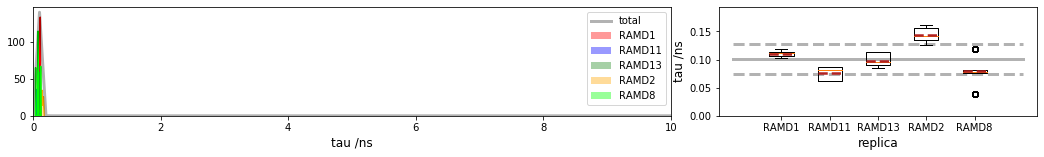

2393979-A-loop-Hel :  tauRAMD=  0.083 +- 0.009
0.101
Average over replicas:        tauRAMD =   0.083 +- 0.009


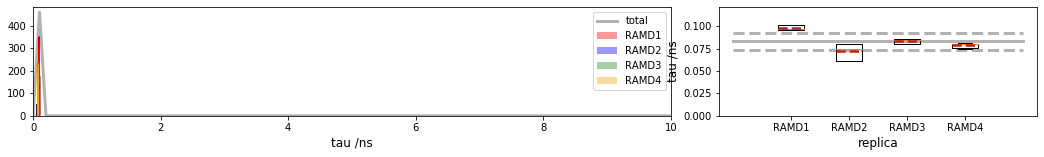

2393980-A-loop-Hel :  tauRAMD=  0.065 +- 0.012
0.094
Average over replicas:        tauRAMD =   0.065 +- 0.012


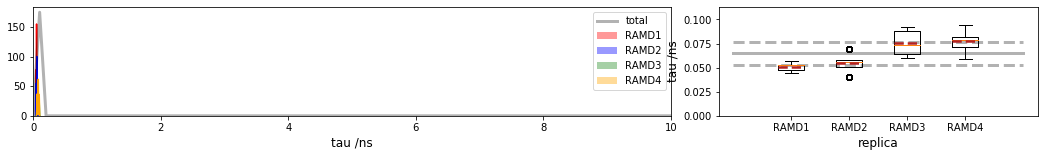

2362376 :  tauRAMD=  0.129 +- 0.033
0.2205
Average over replicas:        tauRAMD =   0.129 +- 0.033


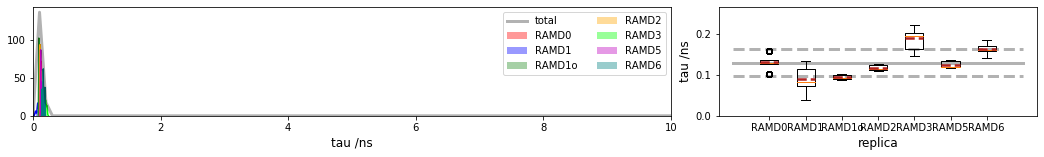

2394590-PROT-conf2 :  tauRAMD=  0.878 +- 0.664
2.482
Average over replicas:        tauRAMD =   0.878 +- 0.664


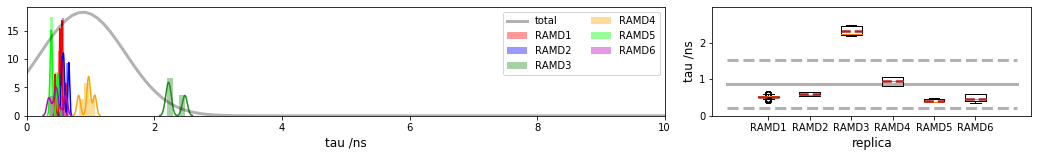

2394590 :  tauRAMD=  0.382 +- 0.093
0.6134999999999999
Average over replicas:        tauRAMD =   0.382 +- 0.093


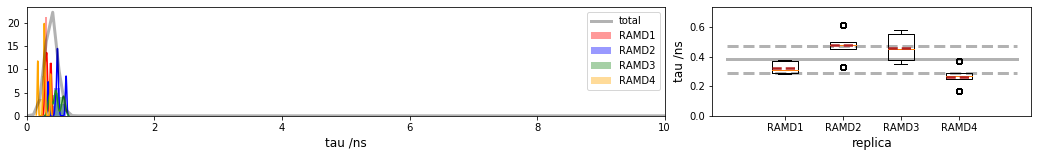

2529902 :  tauRAMD=  0.922 +- 0.314
1.963
Average over replicas:        tauRAMD =   0.922 +- 0.314


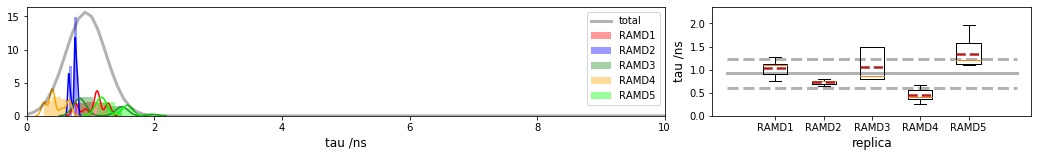

2306349 :  tauRAMD=  0.659 +- 0.323
1.0935000000000001
Average over replicas:        tauRAMD =   0.659 +- 0.323


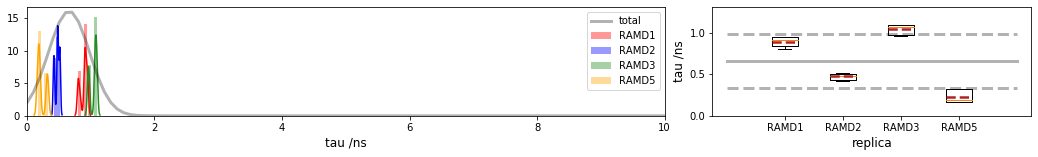

2393979 :  tauRAMD=  0.06 +- 0.015
0.08449999999999999
Average over replicas:        tauRAMD =   0.06 +- 0.015


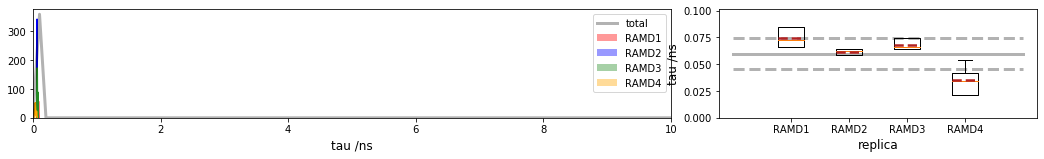

2216855-PROT-conf2 :  tauRAMD=  0.638 +- 0.293
1.4969999999999999
Average over replicas:        tauRAMD =   0.638 +- 0.293


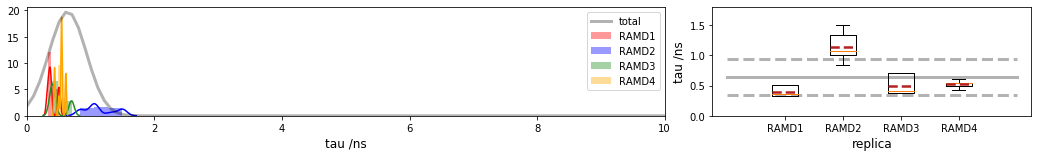

2396008-PROT-conf2 :  tauRAMD=  0.51 +- 0.305
1.114
Average over replicas:        tauRAMD =   0.51 +- 0.305


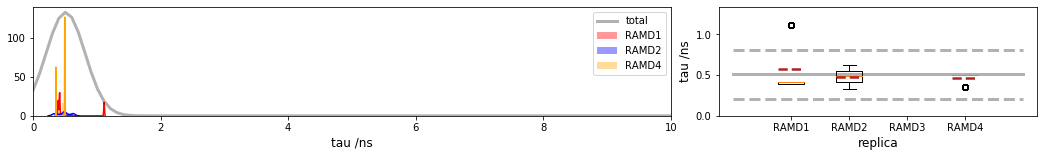

2324090 :  tauRAMD=  0.119 +- 0.036
0.195
Average over replicas:        tauRAMD =   0.119 +- 0.036


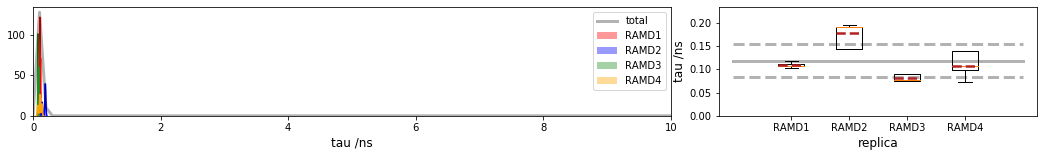

2396722 :  tauRAMD=  0.122 +- 0.042
0.191
Average over replicas:        tauRAMD =   0.122 +- 0.042


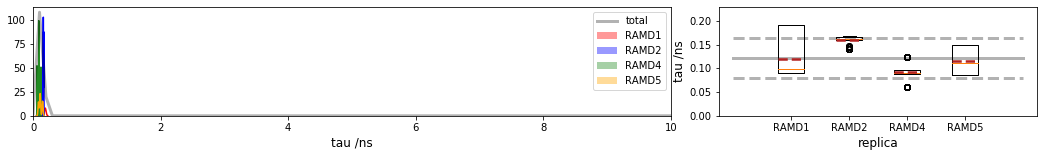

2324090-loop :  tauRAMD=  0.137 +- 0.042
0.2515
Average over replicas:        tauRAMD =   0.137 +- 0.042


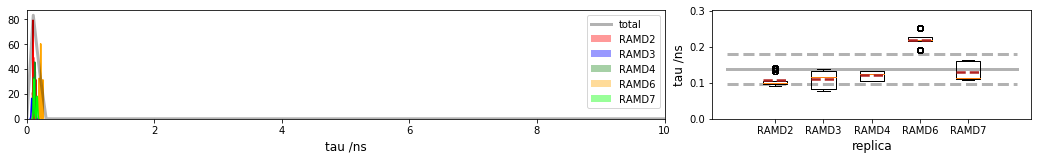

2393980 :  tauRAMD=  0.059 +- 0.009
0.07650000000000001
Average over replicas:        tauRAMD =   0.059 +- 0.009


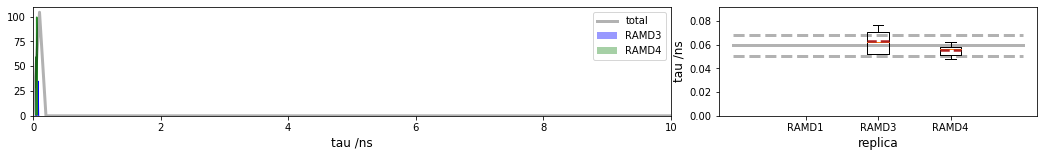

2393979-helix-docking-1 :  tauRAMD=  0.109 +- 0.039
0.231
Average over replicas:        tauRAMD =   0.109 +- 0.039


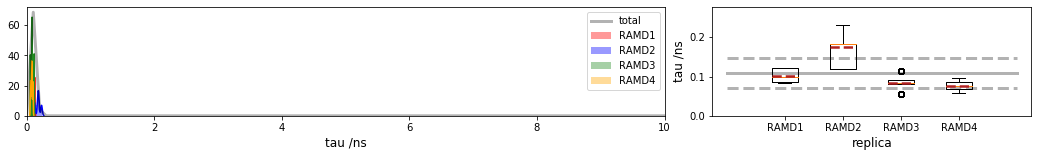

1ucyh :  tauRAMD=  2.804 +- 1.024
5.0475
Average over replicas:        tauRAMD =   2.804 +- 1.024


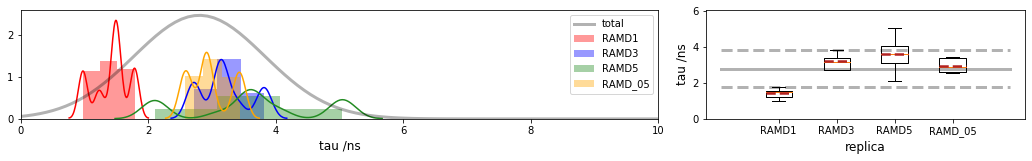

2396008 :  tauRAMD=  1.788 +- 1.457
4.631500000000001
Average over replicas:        tauRAMD =   1.788 +- 1.457


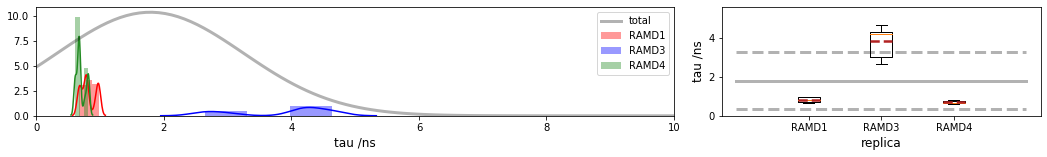

2393979-A-loop-L :  tauRAMD=  0.068 +- 0.012
0.093
Average over replicas:        tauRAMD =   0.068 +- 0.012


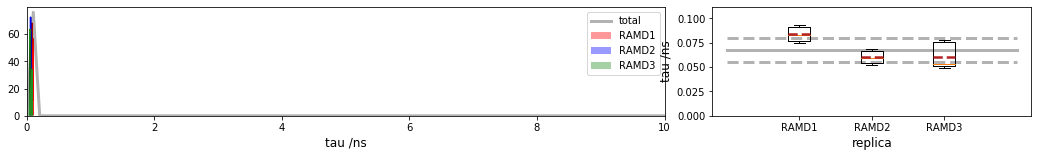

In [6]:
######################
#
#    tauRAMD analysis for FAK
#
#######################

DIR_all = "/hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/"
DIR_namd = "NAM*"
DIR_ramd = "RAMD*"
ref = "ref.pdb"


#ramd_trj = "*8_out/*dcd"
ref = "ref.pdb"
ligandPDB = "INH.pdb"
ligandMol2 = "moe.mol2"

    

tr_FAK = []
tr_FAK_name = []

col =  cm.rainbow(np.linspace(0, 1, 6))

#------------ loop over ligands
for i,dir_ligand in enumerate(glob.glob(DIR_all+"/*")): 
    if  os.path.isfile(dir_ligand+"/"+ref):
        lig_name=os.path.basename(dir_ligand)
        line = exp_data[exp_data["filename"].astype(str) == lig_name].shape[0]
        print("=======================",lig_name,"===============================")
        if line > 0:
            tr = trajectories(dir_ligand,namd_tmpl= DIR_namd, ramd_tmpl= DIR_ramd,ligand_pdb=ligandPDB,\
                          ligand_mol2=ligandMol2,namd_traj_tmpl = "*dcd",ramd_traj_tmpl = ramd_trj)
        
            if(len(tr.ramd.repl_traj) == 0):
                print("\nSKIP ",i,dir_ligand,"RAMD data are missing; NAMD trajectories generated",len(tr.namd.repl_traj))
            else: 
                print("\n",i,tr.tau_exp,"NAMD generated %s; RAMD generated %s  " %(len(tr.namd.repl_traj),len(tr.ramd.repl_traj)))
                tr.ramd.scan_ramd()
                tr_FAK.append(tr)
                tr_FAK_name.append(os.path.basename(dir_ligand))

            
print("===\nComplete (NAMD+RAMD) simulations found for %i compounds)"  %(len(tr_FAK)))

########################################################
# Plot computed residence times
##########################################################

for tr, name in zip(tr_FAK,tr_FAK_name):
    filename = os.path.basename(tr.PRJ_DIR[:-1])
    line = exp_data[exp_data["filename"].astype(str) == filename].shape[0]
    if line > 0:
        try: 
            print (name, ": " , "tauRAMD= ",np.round(tr.ramd.tau,3),"+-",np.round(tr.ramd.tau_SD,3))
            tr.ramd.Plot_RAMD((0,10))
        except:
            print(name,":  missing data")


Outliers:  ['MSC008']
R2 = 0.9390639617784713
Outliers:  ['PF271' 'MSC979' 'MSC980' 'MSC008']
R2 = 1.0


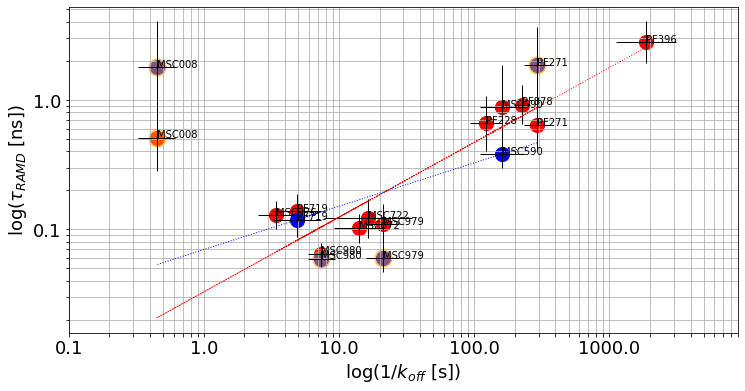

In [7]:
########################################
#
#     PLOT tauRAMD evaluation for a set of compounds with available exp.data
#
########################################
def PLOT_tauRAMD_dataset(tr,tr_name = None,types_list = [""],xlims=[0,3]):
    """
    Parameters:
    tr_FAK_- a set of trajectory objects (for each ligand)
    tr_FAK_name - name of the ligand to be indicated in the plot
    types_list - a list of ligand types to be shown in different colors
    Returns:
    """
    fig = plt.figure(figsize=(12, 6))
    color = ['r','b','green','m','c','orange','yellow','goldenrod','olive','tomato','salmon','seagreen']
    #color =  cm.rainbow(np.logspace(0.1, 1, len(tr)))
    plt.xlim(xlims)
    if tr_name:
        if (len(tr) != len(tr_name)): tr_name = None
            
    x_tick_lable = []
    x_tick_pos = []
    for k in range(0,5):
        for ii,i in enumerate(range(pow(10,k),pow(10,k+1),pow(10,k))):  
            if(ii == 0): x_tick_lable.append(str(i/10.))
            else: x_tick_lable.append("")
            x_tick_pos.append(np.log10(i/10.))
    y_tick_lable = []
    y_tick_pos = []
    
    for k in range(0,4):
        for ii,i in enumerate(range(pow(10,k),pow(10,k+1),pow(10,k))):            
            if(ii == 0): y_tick_lable.append(str(i/100.))
            else: y_tick_lable.append("")
            y_tick_pos.append(np.log10(i/100.))
            
            
    for i,type_comp in enumerate(types_list):        
        X = []
        y = []
        X_err = []
        y_err = []
        txt = []
        for j,t in enumerate(tr):
            if t.tau_exp and t.ramd.tau:
                if ((t.type == type_comp) or ( t.type == "")):
                    X.append(np.log10(t.ramd.tau))
                    y.append(t.tau_exp)
                    y_err.append(t.tau_exp_SD)
                    X_err.append(1/(t.ramd.tau*np.log(10))*t.ramd.tau_SD)
                    if tr_name:
                        txt.append(tr_name[j]) 
        ax = fig.add_subplot(111)
        plt.errorbar(x=y,y=X,xerr=y_err,yerr= X_err, color = "black" , fmt='o', markersize=1,lw=1 )
        plt.scatter(x=y,y=X, color = color[i] , s=200 )
        plt.xticks(x_tick_pos,x_tick_lable, fontsize=18)
        plt.yticks(y_tick_pos,y_tick_lable, fontsize=18)
        try:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x=y,y=X)
            fitt = np.asarray(y)*slope+intercept
            ind = np.argwhere(np.abs(fitt-X) < 0.5).flatten()
            slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.asarray(y)[ind],y=np.asarray(X)[ind])
            ind = np.argwhere(np.abs(fitt-X) >= 0.5).flatten()
            fitt = np.asarray(y)*slope+intercept
            if (len(ind) > 0):
                if tr_name: print("Outliers: ",np.asarray(txt)[ind])
                plt.scatter(x=np.asarray(y)[ind],y=np.asarray(X)[ind],color = 'orange',alpha=0.5,s=300)
            plt.plot(y,fitt,color = color[i],linewidth=1,linestyle='dotted')
        except:
            pass
        ax.set_xlabel(r'log($1/k_{off} $ [s])',fontsize=18)
        ax.set_ylabel(r'log($\tau_{RAMD} $ [ns])',fontsize=18)
        plt.grid(True)
        if tr_name:
            for j, t in enumerate(txt):    ax.annotate(t, (y[j], X[j]))
        print("R2 =",r_value)
    return


l = []    
for i,tr in enumerate(tr_FAK):
        filename = os.path.basename(tr.PRJ_DIR[:-1])
        ligname = filename
        l.append(ligname)
#        print(i," =======================",filename,"==",ligname,"=============================")
        try:
            line = exp_data[exp_data["filename"].astype(str) == ligname]
            tr.tau_exp = line.koff.values[0]
            tr.tau_exp_SD = line.koff_SD.values[0]
            if(line.koff_SD.values[0] > 0):
                   tr.tau_exp_SD = 1/(tr.tau_exp*np.log(10))*tr.tau_exp_SD
            else:   tr.tau_exp_SD = 1/(tr.tau_exp*np.log(10))*0.01
            tr.type = line.type.values[0]
            tr.tau_exp = np.log10(1./tr.tau_exp)
            l[-1] = line.paper.values[0]
            print(">>>>>>> Exp data for ",i," ",filename," : ",tr.tau,tr.tau_exp,tr.tau_exp_SD,tr.type)
        except:
#            print("Exp data not found for ",filename,ligname)
            pass


# final evaluation of tauRAMD simulations
PLOT_tauRAMD_dataset(tr=tr_FAK,tr_name = l,types_list = [1,2],xlims=[0,1])


##  Explore different conformations for comp. MSC979 in FAK

2216855 1.85565871743487 1.245053379271553
2216855-PROT-conf2 0.6379133266533066 0.2930876140497744


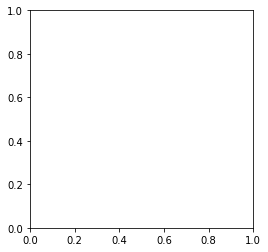

In [8]:
t_tau = []
t_tau_sd = []
t_name = []
indx = []
for i,(tr,name) in enumerate(zip(tr_FAK,tr_FAK_name)):
    if name.find("855")>0:
        print(name, tr.ramd.tau, tr.ramd.tau_SD)
        t_tau.append(tr.ramd.tau)
        t_tau_sd.append(tr.ramd.tau_SD)
        t_name.append(name)
        indx.append(i)
     
#----- generate PDB from the last snapshot of each NAMD equilibration    
"""
for ind in indx:
    ref = mda.Universe(tr_FAK[ind].PRJ_DIR+tr_FAK[ind].pdb)
    Rgr0 = ref.select_atoms("protein").radius_of_gyration()
    print(ind,"--",tr_FAK[ind].PRJ_DIR)
    for j,traj in enumerate(tr_FAK[ind].namd.repl_traj):
        u = mda.Universe(tr_FAK[ind].PRJ_DIR+tr_FAK[ind].pdb)
        u.load_new(traj)  
        u_length = len(u.trajectory)
        system_reduced = u.select_atoms('protein or resname INH')
        u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=-2,stop=-1,step=5).results,format=MemoryReader)
        u_mem.dimensions = u.dimensions
        Rgr = pbc(u_mem,Rgr0)
        rmsd = superimpose_traj(ref,u_mem,["protein","resname INH"]) 
        print(traj[-20:],"RMSD (protein , ligand):",rmsd,"traj length:",u_length)
        all_write = u_mem.select_atoms("all")
        all_write.write(tr_FAK[ind].PRJ_DIR+"/traj_protein-f-"+str(ind)+"-"+str(j)+".pdb")
"""
try:
    indx = np.array([1,2,3,4])
    fig, ax = plt.subplots(figsize=(4, 4))
    x_pos = np.arange(indx.shape[0])
    ax.bar(x_pos, np.asarray(t_tau)[indx], yerr=np.asarray(t_tau_sd)[indx], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(r'$\tau_{RAMD} $ [ns]',fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(np.asarray(t_name)[indx],rotation=45,fontsize=12)
    ax.set_title('')
    ax.yaxis.grid(True)

# Save the figure and show
    plt.tight_layout()
#plt.savefig('MSC979_conf_bars.png',dpi=300)
    plt.show()

    np.asarray(t_name) 
except:
    pass

# 2. Analysis of PYK  residence times

##  Explore different conformations for comp. MSC590 in PYK2 

/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2396008.sh.o5444058/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/3fzr.cif/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2306349_dock.sh.o5443990/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2216855_5tob.sh.o5443187/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2394590_5tob-A.sh.o5444056/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2216855_5tob-dfg.sh.o5444121/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2396008.sh.o5443979/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2216855_5tob-dfg.sh/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/cmp3-2.png/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2396722.sh/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-1ucyh.sh.o5443981/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2216855_5tob-A.

15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/2394590/RAMD3
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/2394590/RAMD4

 45 None NAMD generated 5; RAMD generated 4  
RAMD1 tau= 0.051 +- 0.008 [0.042, 0.094, 0.021, 0.042, 0.038, 0.065, 0.034, 0.20700000000000002, 0.09, 0.083, 0.069, 0.031, 0.045, 0.07200000000000001, 0.034]
RAMD2 tau= 0.04 +- 0.004 [0.038, 0.041, 0.032, 0.116, 0.181, 0.019, 0.129, 0.033, 0.028, 0.032, 0.085, 0.039, 0.019, 0.056, 0.057]
RAMD3 tau= 0.084 +- 0.005 [0.056, 0.123, 0.091, 0.094, 0.077, 0.057, 0.027, 0.083, 0.078, 0.097, 0.154, 0.109, 0.112, 0.049, 0.069]
RAMD4 tau= 0.066 +- 0.002 [0.031, 0.063, 0.07100000000000001, 0.074, 0.029, 0.063, 0.049, 0.097, 0.094, 0.067, 0.053, 0.052000000000000005, 0.068, 0.11800000000000001, 0.083]
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/cmp3-4.png/ref.pdb not found
======================= 2529902 ===============================
Ligand properties:
Donor ['N8', 'N23', 'N25']
Acceptor ['N10',


SKIP  68 /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/2394590_dock2 RAMD data are missing; NAMD trajectories generated 4
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2216855_5tob-dfg.sh.o5444057/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2216855_5tob-dfg.sh.o5444041/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2396722.sh.o5444051/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2324090_3h3c.sh.o5444046/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2363072.sh.o5443999/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2529902.sh.o5443993/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2216855_pos5tob.sh/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2394590_5tob-A.sh.o5443998/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/2362376_dock.log/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2394590_dock2.sh/ref.pdb not fou

Ligand properties:
Donor ['N11', 'N20', 'N22']
Acceptor ['N3', 'N5', 'O21', 'O33', 'O35']
Aromatic ['C1', 'C2', 'N3', 'C4', 'N5', 'C6', 'C12', 'C13', 'C17', 'C16', 'C14', 'C15', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29']
Hydrophobe ['C1', 'C13', 'C14', 'C15', 'C17', 'C18', 'C24', 'C25', 'C26', 'C27', 'C28', 'C34', 'F10', 'F8', 'F9']
LumpedHydrophobe ['C12', 'C13', 'C17', 'C16', 'C14', 'C15', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29']
4  Equilibration trajectories found
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/1ucyh_3fzr/RAMD1
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/1ucyh_3fzr/RAMD2
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/1ucyh_3fzr/RAMD3
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/1ucyh_3fzr/RAMD4

 113 None NAMD generated 4; RAMD generated 4  
RAMD1 tau= 0.159 +- 0.018 [0.161, 0.052000000000000005, 0.058, 0.365, 0.068, 0.159, 0.09, 0.061, 0.4, 0.352, 0.28500000000000003, 0.17, 0.249, 0.199

15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/2394590_pos5tob/RAMD1
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/2394590_pos5tob/RAMD2
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/2394590_pos5tob/RAMD3
15  RAMD traj. found in  /hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/2394590_pos5tob/RAMD4

 136 None NAMD generated 4; RAMD generated 4  
RAMD1 tau= 0.082 +- 0.014 [0.06, 0.021, 0.03, 0.09, 0.185, 0.048, 0.181, 0.161, 0.035, 0.083, 0.132, 0.162, 0.127, 0.063, 0.035]
RAMD2 tau= 0.051 +- 0.004 [0.041, 0.045, 0.113, 0.037, 0.061, 0.063, 0.039, 0.138, 0.045, 0.056, 0.026000000000000002, 0.032, 0.064, 0.125, 0.052000000000000005]
RAMD3 tau= 0.056 +- 0.005 [0.138, 0.07, 0.064, 0.035, 0.052000000000000005, 0.027, 0.027, 0.03, 0.07, 0.051000000000000004, 0.051000000000000004, 0.083, 0.092, 0.052000000000000005, 0.094]
RAMD4 tau= 0.061 +- 0.008 [0.082, 0.045, 0.09, 0.054, 0.049, 0.045, 0.151, 0.149, 0.075, 0.031, 0.078, 0.08, 0.053, 0.03


 159 None NAMD generated 4; RAMD generated 4  
RAMD1 tau= 0.069 +- 0.009 [0.123, 0.17400000000000002, 0.17, 0.079, 0.039, 0.028, 0.058, 0.116, 0.051000000000000004, 0.106, 0.035, 0.066, 0.053, 0.092, 0.041]
RAMD2 tau= 0.085 +- 0.021 [0.053, 0.088, 0.039, 0.619, 0.06, 0.234, 0.07, 0.31, 0.073, 0.34800000000000003, 0.053, 0.067, 0.329, 0.026000000000000002, 0.17200000000000001]
RAMD3 tau= 0.093 +- 0.007 [0.059000000000000004, 0.069, 0.101, 0.084, 0.079, 0.114, 0.047, 0.07100000000000001, 0.093, 0.47700000000000004, 0.17300000000000001, 0.302, 0.112, 0.057, 0.256]
RAMD4 tau= 0.081 +- 0.015 [0.027, 0.129, 0.123, 0.074, 0.038, 0.029, 0.054, 0.037, 0.20800000000000002, 0.133, 0.131, 0.314, 0.067, 0.097, 0.05]
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2363072.sh.o5444055/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/msc590-2.png/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/IFP_env-2216855_5tob-dfg.sh.o5444047/ref.pdb not found
/hits/fast/mcm/kokhda/FAK-PYK2/

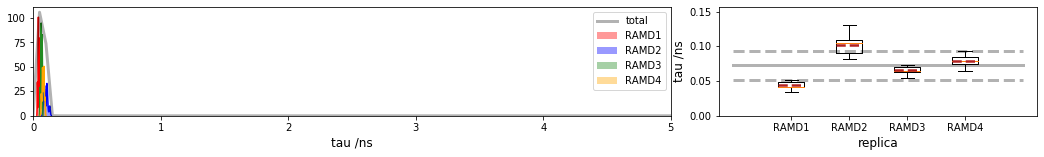

2394590_5tob :  tauRAMD=  0.046 +- 0.011
0.065
Average over replicas:        tauRAMD =   0.046 +- 0.011


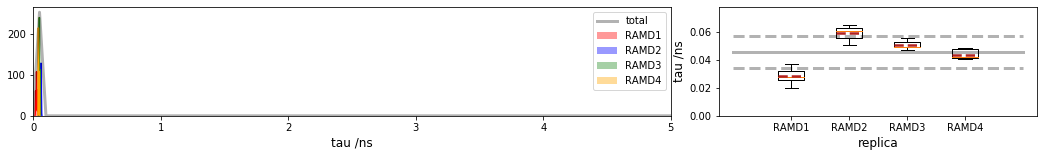

2362376 :  tauRAMD=  0.113 +- 0.022
0.169
Average over replicas:        tauRAMD =   0.113 +- 0.022


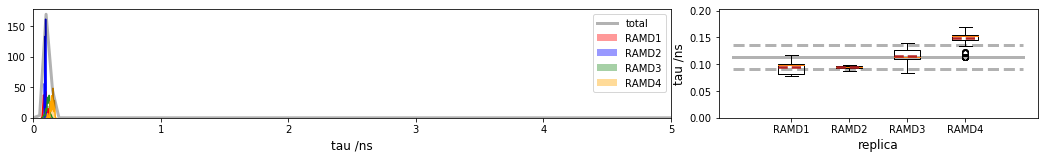

2394590 :  tauRAMD=  0.06 +- 0.017
0.0925
Average over replicas:        tauRAMD =   0.06 +- 0.017


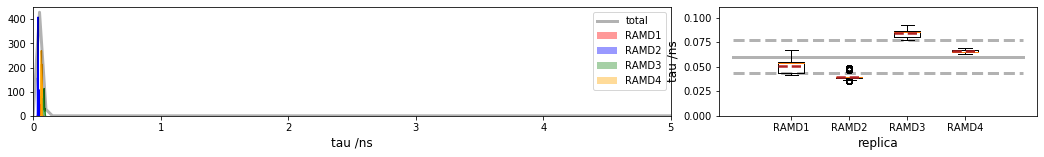

2529902 :  tauRAMD=  0.118 +- 0.019
0.179
Average over replicas:        tauRAMD =   0.118 +- 0.019


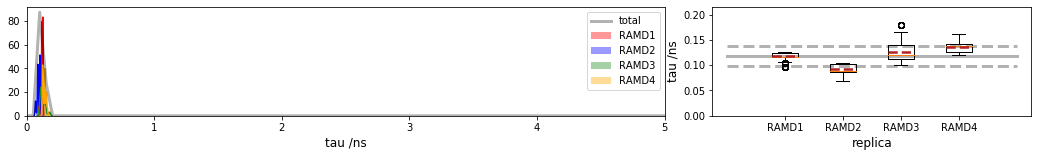

2306349 :  tauRAMD=  0.101 +- 0.021
0.154
Average over replicas:        tauRAMD =   0.101 +- 0.021


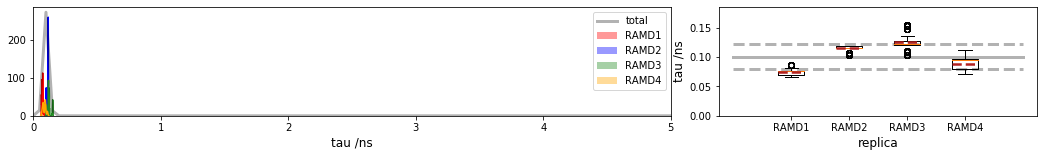

2393979 :  tauRAMD=  0.044 +- 0.005
0.0555
Average over replicas:        tauRAMD =   0.044 +- 0.005


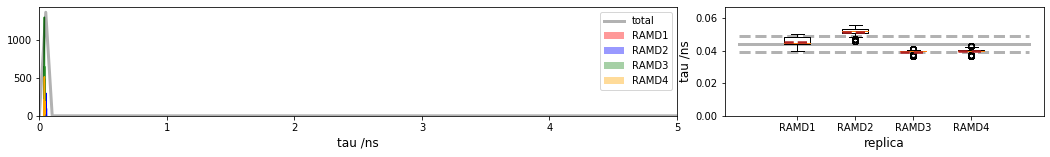

2396008_dock :  tauRAMD=  0.117 +- 0.052
0.266
Average over replicas:        tauRAMD =   0.117 +- 0.052


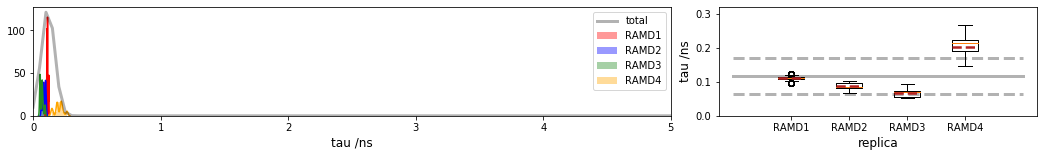

2324090_3h3c :  tauRAMD=  0.08 +- 0.015
0.1265
Average over replicas:        tauRAMD =   0.08 +- 0.015


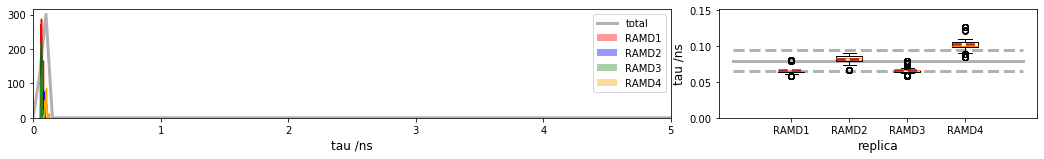

2216855_5tob :  tauRAMD=  0.092 +- 0.021
0.131
Average over replicas:        tauRAMD =   0.092 +- 0.021


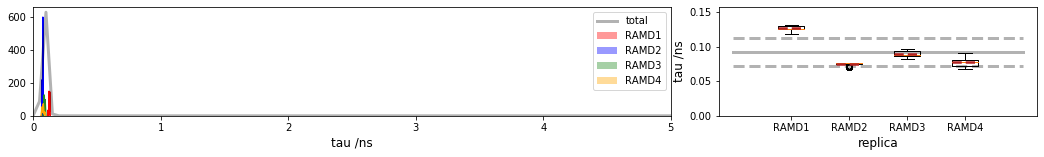

2306349_dock :  tauRAMD=  0.081 +- 0.017
0.11800000000000001
Average over replicas:        tauRAMD =   0.081 +- 0.017


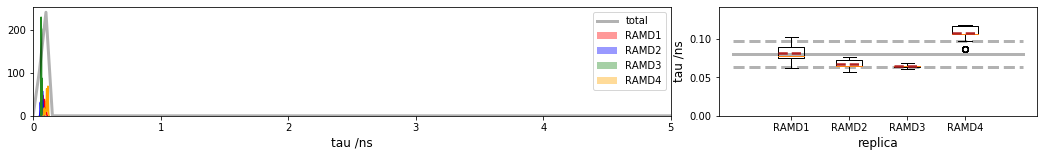

1ucyh_3fzr :  tauRAMD=  0.109 +- 0.031
0.1845
Average over replicas:        tauRAMD =   0.109 +- 0.031


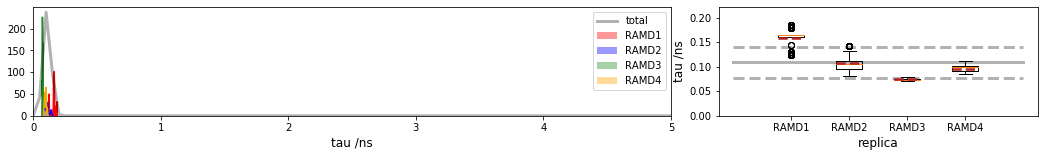

2396722 :  tauRAMD=  0.069 +- 0.008
0.0845
Average over replicas:        tauRAMD =   0.069 +- 0.008


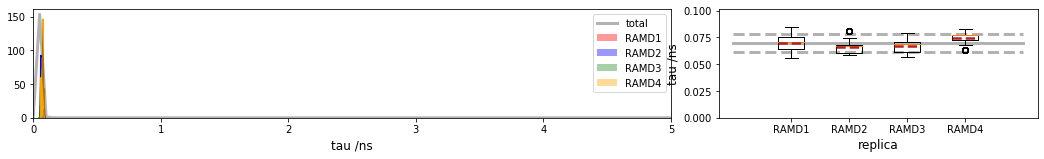

2393980 :  tauRAMD=  0.046 +- 0.008
0.069
Average over replicas:        tauRAMD =   0.046 +- 0.008


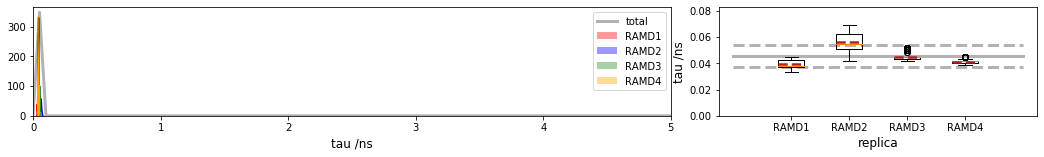

2394590_5tob-A :  tauRAMD=  0.105 +- 0.042
0.198
Average over replicas:        tauRAMD =   0.105 +- 0.042


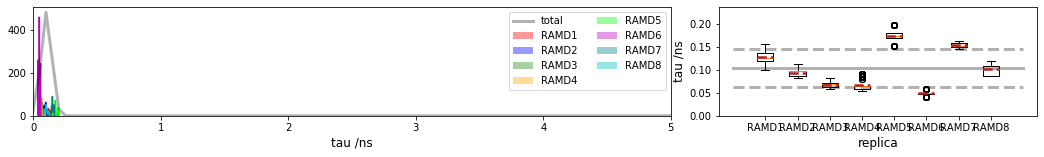

2394590_pos5tob :  tauRAMD=  0.063 +- 0.014
0.1085
Average over replicas:        tauRAMD =   0.063 +- 0.014


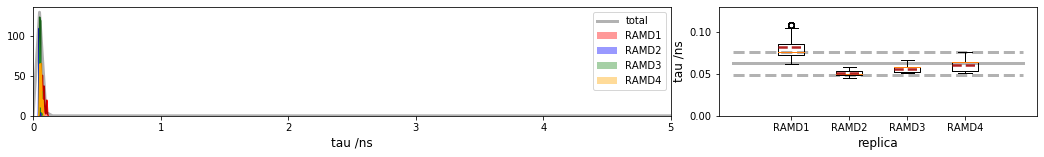

2394590_asfak :  tauRAMD=  0.218 +- 0.099
0.514
Average over replicas:        tauRAMD =   0.218 +- 0.099


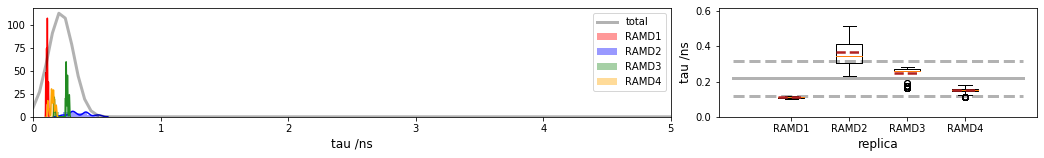

2216855-5tob-dfgin :  tauRAMD=  0.077 +- 0.011
0.0965
Average over replicas:        tauRAMD =   0.077 +- 0.011


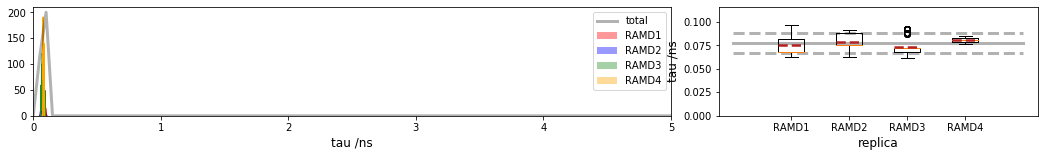

2362376_dock :  tauRAMD=  0.065 +- 0.009
0.088
Average over replicas:        tauRAMD =   0.065 +- 0.009


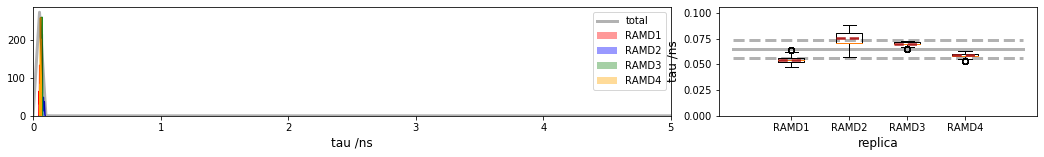

2396008 :  tauRAMD=  0.092 +- 0.013
0.1195
Average over replicas:        tauRAMD =   0.092 +- 0.013


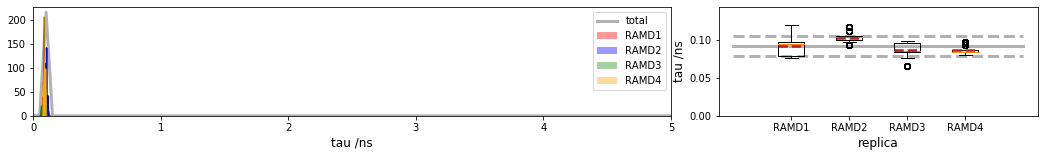

2394590_dock6 :  tauRAMD=  0.082 +- 0.021
0.13
Average over replicas:        tauRAMD =   0.082 +- 0.021


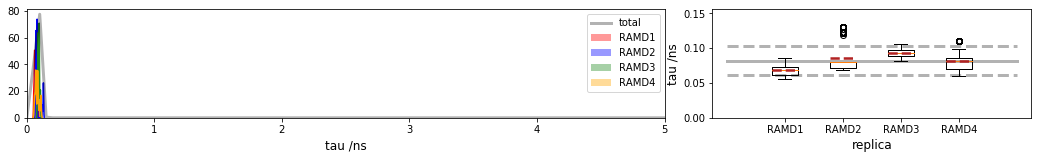

In [9]:
######################
#
#    tauRAMD analysis for FAK
#
#######################

DIR_all_P = "/hits/fast/mcm/kokhda/FAK-PYK2/PYK2/RAMD/"
DIR_namd = "NAMD*"
DIR_ramd = "RAMD*"
ref = "ref.pdb"


#ramd_trj = "*8_out/*dcd"
ref = "ref.pdb"
ligandPDB = "INH.pdb"
ligandMol2 = "moe.mol2"


    

tr_PYK = []
tr_PYK_name = []

col =  cm.rainbow(np.linspace(0, 1, 6))

#------------ loop over ligands
for i,dir_ligand in enumerate(glob.glob(DIR_all_P+"/*")): 
    if  os.path.isfile(dir_ligand+"/"+ref):
        lig_name=os.path.basename(dir_ligand)
        line = exp_data[exp_data["filename"].astype(str) == lig_name].shape[0]
        print("=======================",lig_name,"===============================")
        if line > 0:
            tr = trajectories(dir_ligand,namd_tmpl= DIR_namd, ramd_tmpl= DIR_ramd,ligand_pdb=ligandPDB,\
                          ligand_mol2=ligandMol2,namd_traj_tmpl = "*dcd",ramd_traj_tmpl = ramd_trj)
        
            if(len(tr.ramd.repl_traj) == 0):
                print("\nSKIP ",i,dir_ligand,"RAMD data are missing; NAMD trajectories generated",len(tr.namd.repl_traj))
            else: 
                print("\n",i,tr.tau_exp,"NAMD generated %s; RAMD generated %s  " %(len(tr.namd.repl_traj),len(tr.ramd.repl_traj)))
                tr.ramd.scan_ramd()
                tr_PYK.append(tr)
                tr_PYK_name.append(os.path.basename(dir_ligand))
    else: print(dir_ligand+"/"+ref, "not found")
            
print("===\nComplete (NAMD+RAMD) simulations found for %i compounds)"  %(len(tr_PYK)))

    
for tr, name in zip(tr_PYK,tr_PYK_name):
    filename = os.path.basename(tr.PRJ_DIR[:-1])
    line = exp_data[exp_data["filename"].astype(str) == filename].shape[0]
    if line > 0:
        try: 
            print (name, ": " , "tauRAMD= ",np.round(tr.ramd.tau,3),"+-",np.round(tr.ramd.tau_SD,3))
            tr.ramd.Plot_RAMD((0,5))
        except:
            print(name,":  missing data")


>>>>>>> Exp data for  0   2363072  :  0.596879478824182 0.18367395084445826 3
>>>>>>> Exp data for  1   2394590_5tob  :  1.7569619513137056 0.1938194230665369 4
>>>>>>> Exp data for  2   2362376  :  0.12493873660829992 0.18298274170857007 4
>>>>>>> Exp data for  3   2394590  :  1.7569619513137056 0.1938194230665369 4
>>>>>>> Exp data for  4   2529902  :  1.4473317838878068 0.1386822715321308 3
>>>>>>> Exp data for  5   2306349  :  0.47625353318843544 0.14433139967443398 4
>>>>>>> Exp data for  6   2393979  :  nan nan 4
>>>>>>> Exp data for  7   2396008_dock  :  0.2628073572952628 0.1463556495791178 4
>>>>>>> Exp data for  8   2324090_3h3c  :  1.2628073572952627 0.06212160995722337 3
>>>>>>> Exp data for  9   2216855_5tob  :  1.1301817920206718 0.1435926424646379 4
>>>>>>> Exp data for  10   2306349_dock  :  0.47625353318843544 0.14433139967443398 3
>>>>>>> Exp data for  11   1ucyh_3fzr  :  1.393618634889395 0.1311483336440513 3
>>>>>>> Exp data for  12   2396722  :  0.7144426909922262 

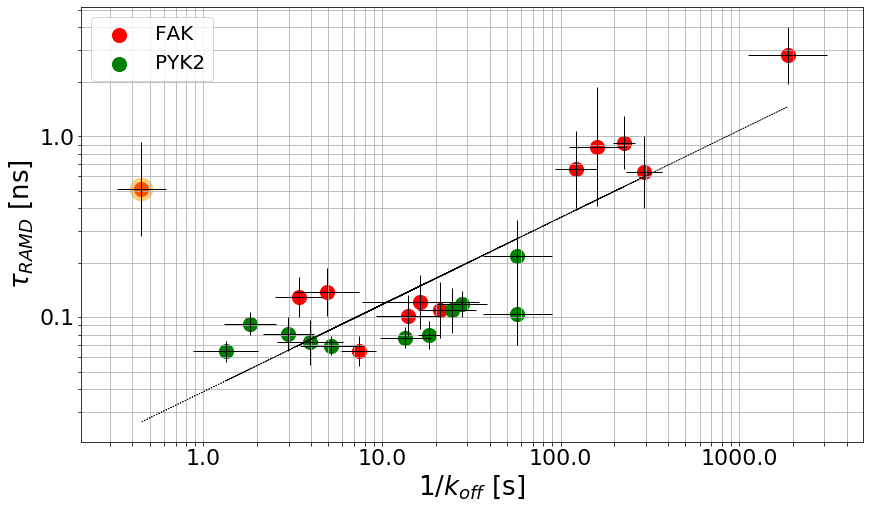

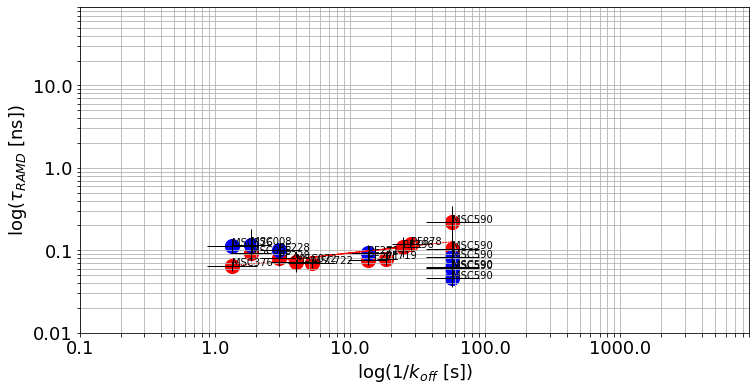

In [10]:
#################################
#   Plot comparison with exp data
##################################

l1 = []  
exp_dataP = exp_data[exp_data.type >= 3]
for i,(tr,name) in enumerate(zip(tr_PYK,tr_PYK_name)):
        filename = os.path.basename(tr.PRJ_DIR[:-1])
        ligname = filename
        l1.append(ligname)
#        print(i," =======================",filename,"==",ligname,"=============================")
        try:
            line = exp_dataP[exp_dataP["filename"].astype(str) == ligname]
 #           print(line)
            tr.tau_exp = line.koff.values[0]
            tr.tau_exp_SD = line.koff_SD.values[0]
            if(line.koff_SD.values[0] > 0):
                   tr.tau_exp_SD = 1/(tr.tau_exp*np.log(10))*tr.tau_exp_SD
            else:   tr.tau_exp_SD = 1/(tr.tau_exp*np.log(10))*0.01
            tr.type = line.type.values[0]
            tr.tau_exp = np.log10(1./tr.tau_exp)
            l1[-1] = line.paper.values[0]
            print(">>>>>>> Exp data for ",i," ",filename," : ",tr.tau_exp,tr.tau_exp_SD,tr.type)
        except:
#            print("Exp data not found for ",filename,ligname)
            pass


# final evaluation of tauRAMD simulations
PLOT_tauRAMD_2datasets(tr=tr_FAK,tr_name = l,types_list = [1],tr1=tr_PYK,tr1_name = l1,types_list1 = [3])
PLOT_tauRAMD_dataset(tr_PYK,l1, [3,4])

## Save the last frame from each equalibration replica  for one ligand
##  And compare residence times

In [92]:
tr_FAK_name

['2216855',
 '2363072',
 '2393979-A-loop-Hel',
 '2393980-A-loop-Hel',
 '2362376',
 '2394590-PROT-conf2',
 '2394590',
 '2529902',
 '2306349',
 '2393979',
 '2216855-PROT-conf2',
 '2396008-PROT-conf2',
 '2324090',
 '2396722',
 '2324090-loop',
 '2393980',
 '2393979-helix-docking-1',
 '1ucyh',
 '2396008',
 '2393979-A-loop-L']

In [25]:
t_tau = []
t_tau_sd = []
t_name = []
indx = []
for i,(tr,name) in enumerate(zip(tr_FAK,tr_FAK_name)):
    if name.find("590")>0:
        print(name, tr.ramd.tau, tr.ramd.tau_SD)
        t_tau.append(tr.ramd.tau)
        t_tau_sd.append(tr.ramd.tau_SD)
        t_name.append(name)
        indx.append(i)
     
    
##----- generate PDB from the last snapshot of each NAMD equilibration    

for ind in indx:
    ref = mda.Universe(tr_FAK[ind].PRJ_DIR+tr_FAK[ind].pdb)
    Rgr0 = ref.select_atoms("protein").radius_of_gyration()
    print(ind,"--",tr_FAK[ind].PRJ_DIR)
    for j,traj in enumerate(tr_FAK[ind].namd.repl_traj):
        u = mda.Universe(tr_FAK[ind].PRJ_DIR+tr_FAK[ind].pdb)
        u.load_new(traj)  
        u_length = len(u.trajectory)
        system_reduced = u.select_atoms('protein or resname INH')
        u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=-300,stop=-1,step=300).results,format=MemoryReader)
        u_mem.dimensions = u.dimensions
        Rgr = pbc(u_mem,Rgr0)
        rmsd = superimpose_traj(ref,u_mem,["protein","resname INH"]) 
        print(j,traj[-20:],"RMSD (protein , ligand):",rmsd,"traj length:",u_length)
        all_write = u_mem.select_atoms("protein")  #("all")
        all_write.write(tr_FAK[ind].PRJ_DIR+"/trajO_protein-f-"+str(ind)+"-"+str(j)+".pdb")


2394590-PROT-conf2 0.8746317635270541 0.6605263184453363
2394590 0.38710320641282564 0.09703473491570697
5 -- /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2394590-PROT-conf2/
0 NAMD1/amber2namd.dcd RMSD (protein , ligand): [2.493003039534922, 1.6535540258904222] traj length: 5219
1 NAMD2/amber2namd.dcd RMSD (protein , ligand): [2.8487312574058747, 1.5122339518474572] traj length: 8654
2 NAMD3/amber2namd.dcd RMSD (protein , ligand): [2.5338745666397755, 1.510197279540196] traj length: 8641
3 NAMD4/amber2namd.dcd RMSD (protein , ligand): [2.4951070031187785, 1.4733305540629593] traj length: 672
4 NAMD5/amber2namd.dcd RMSD (protein , ligand): [2.1188431522745916, 1.3756339582755575] traj length: 663
5 NAMD6/amber2namd.dcd RMSD (protein , ligand): [2.549334623307051, 1.4676253601544842] traj length: 660
6 -- /hits/fast/mcm/kokhda/FAK-PYK2/FAK/RAMD/2394590/
0 NAMD1/amber2namd.dcd RMSD (protein , ligand): [1.7353093829809367, 0.9213745987454368] traj length: 10000
1 AMD11/amber2namd.dcd RMSD (pro

In [26]:
t_tau = []
t_tau_sd = []
t_name = []
indx = []
for i,(tr,name) in enumerate(zip(tr_PYK,tr_PYK_name)):
    if name.find("590_asfak")>0:
        print(name, tr.ramd.tau, tr.ramd.tau_SD)
        t_tau.append(tr.ramd.tau)
        t_tau_sd.append(tr.ramd.tau_SD)
        t_name.append(name)
        indx.append(i)
     
    
##----- generate PDB from the last snapshot of each NAMD equilibration    


for ind in indx:
    ref = mda.Universe(tr_PYK[ind].PRJ_DIR+tr_PYK[ind].pdb)
    Rgr0 = ref.select_atoms("protein").radius_of_gyration()
    print(ind,"--",tr_PYK[ind].PRJ_DIR)
    for j,traj in enumerate(tr_PYK[ind].namd.repl_traj):
        u = mda.Universe(tr_PYK[ind].PRJ_DIR+tr_PYK[ind].pdb)
        u.load_new(traj)  
        u_length = len(u.trajectory)
        system_reduced = u.select_atoms('protein or resname INH')
        u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=-150,stop=-1,step=150).results,format=MemoryReader)
        u_mem.dimensions = u.dimensions
        Rgr = pbc(u_mem,Rgr0)
        rmsd = superimpose_traj(ref,u_mem,["protein","resname INH"]) 
        print(j,traj[-20:],"RMSD (protein , ligand):",rmsd,"traj length:",u_length)
        all_write = u_mem.select_atoms("protein") #("all")
        all_write.write(tr_PYK[ind].PRJ_DIR+"/trajL_protein-f-"+str(ind)+"-"+str(j)+".pdb")

try:
    indx = np.array([0,1])
    fig, ax = plt.subplots(figsize=(4, 4))
    x_pos = np.arange(indx.shape[0])
    ax.bar(x_pos, np.asarray(t_tau)[indx], yerr=np.asarray(t_tau_sd)[indx], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(r'$\tau_{RAMD} $ [ns]',fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(np.asarray(t_name)[indx],rotation=45,fontsize=12)
    ax.set_title('')
    ax.yaxis.grid(True)

# Save the figure and show
    plt.tight_layout()
    plt.savefig('MSC590_conf_bars.png',dpi=300)
    plt.show()

    np.asarray(t_name) 
except:
    pass

NameError: name 'tr_PYK' is not defined

##  Visualization of the last equilibration snapshot for a selected compound 

In [ ]:
l = []    
for i,tr in enumerate(tr_PYK):
        filename = os.path.basename(tr.PRJ_DIR[:-1])
        ligname = filename
        l.append(ligname)
#        print(i," =======================",filename,"==",ligname,"=============================")
        try:
            line = exp_data[exp_data["filename"].astype(str) == ligname]
            tr.tau_exp = line.koff.values[0]
            tr.tau_exp_SD = line.koff_SD.values[0]
            if(line.koff_SD.values[0] > 0):
                   tr.tau_exp_SD = 1/(tr.tau_exp*np.log(10))*tr.tau_exp_SD
            else:   tr.tau_exp_SD = 1/(tr.tau_exp*np.log(10))*0.01
            tr.type = line.type.values[0]
            tr.tau_exp = np.log10(1./tr.tau_exp)
            l[-1] = line.paper.values[0]
            print(">>>>>>> Exp data for ",i," ",filename," : ",tr.tau,tr.tau_exp,tr.tau_exp_SD,tr.type)
        except:
#            print("Exp data not found for ",filename,ligname)
            pass

import nglview as nv
view = nv.NGLWidget()

w = []
for ind in np.argwhere(np.asarray(l) =='MSC590'):
    print(tr_PYK_name[ind[0]])
    ref = mda.Universe(tr_PYK[ind[0]].PRJ_DIR+tr_PYK[ind[0]].pdb)
    Rgr0 = ref.select_atoms("protein").radius_of_gyration()
    for traj in tr_PYK[ind[0]].namd.repl_traj:
        u = mda.Universe(tr_PYK[ind[0]].PRJ_DIR+tr_PYK[ind[0]].pdb)
        u.load_new(traj)  
        u_length = len(u.trajectory)
        u.trajectory[-2]
        Rgr = pbc(u,Rgr0)
        rmsd = superimpose_traj(ref,u,["protein","resname INH"]) 
        print(traj[-20:],"RMSD (protein , ligand):",rmsd,"traj length:",u_length)
        protein = u.select_atoms('protein or resname INH')
        w.append(nv.show_mdanalysis(protein))



In [52]:
# select here an object to be visuzlized
m=10
w[m].add_licorice("13 14 15 93 148 149 154")
w[m]

NGLWidget(max_frame=999)

In [53]:
m=11
w[m].add_licorice("13 14 15 93 148 149 154")
w[m]

NGLWidget(max_frame=999)

In [54]:
m=12
w[m].add_licorice("13 14 15 93 148 149 150 154")
w[m]

NGLWidget(max_frame=999)

In [55]:
m=-7
w[m].add_licorice("13 14 15 93 148 149 150 152 154")
w[m]

NGLWidget(max_frame=953)

In [23]:
##############################
#  view some structures
##################################

view = nv.NGLWidget()
#c = view.add_pdbid('1tsu')
#view.add_component('rcsb://1tsu.pdb')
#view
w = []
i = 0
for ind in np.argwhere(np.asarray(l1) =='PF719'):
    print(tr_PYK_name[ind[0]])
    ref = mda.Universe(tr_PYK[ind[0]].PRJ_DIR+tr_PYK[ind[0]].pdb)
    Rgr0 = ref.select_atoms("protein").radius_of_gyration()
    for traj in tr_PYK[ind[0]].namd.repl_traj:
        u = mda.Universe(tr_PYK[ind[0]].PRJ_DIR+tr_PYK[ind[0]].pdb)
        u.load_new(traj)  
        u_length = len(u.trajectory)
        u.trajectory[-1]
        Rgr = pbc(u,Rgr0)
        rmsd = superimpose_traj(ref,u,["protein","resname INH"]) 
        print(i,traj[-20:],"RMSD (protein , ligand):",rmsd,"traj length:",u_length)
        protein = u.select_atoms('protein or resname INH')
        w.append(nv.show_mdanalysis(protein))
        i += 1



NameError: name 'l1' is not defined


## Generation of IFPs for Equilibration step -- test 

In [ ]:
step = 1
auxi_selection = ["((resid 7:20) and (not type H))","((resid 47:64) and (not type H))","((resid 150:156) and (not type H))"]


for tr,name in zip(tr_PYK,tr_PYK_name):
    print("==================  ",name,"  =======================")
##   try:
    if (name.find("2306349") < 0): continue
    #generate IFP
    tr.analysis_all_namd(WB_analysis = True, Lipids = [],auxi_selection = auxi_selection,step_analysis=step, start_analysis=-200)
    # save IFP
    IFP_table = tr.namd.IFP_save(tr.PRJ_DIR+name+"-P-NAMD.pkl")
    sys.stdout.flush()


In [ ]:
step = 10
#auxi_selection = ["((resid 7:20) and (not type H))","((resid 47:64) and (not type H))","((resid 150:156) and (not type H))"]
auxi_selection = ["((resid 8:21) and (not type H))","((resid 48:65) and (not type H))","((resid 151:157) and (not type H))"]


for i,(tr,name) in enumerate(zip(tr_FAK,tr_FAK_name)):
    print("==================  ",i,name,"  =======================")
##   try:
    if (name.find("2324090-loop") < 0): continue
    #generate IFP
    tr.analysis_all_namd(WB_analysis = True, Lipids = [],auxi_selection = auxi_selection,step_analysis=step, start_analysis=-200)
    # save IFP
    IFP_table = tr.namd.IFP_save(tr.PRJ_DIR+name+"-P-NAMD.pkl")

    

In [ ]:
#df = pd.read_pickle(tr.PRJ_DIR+name+"-P-NAMD.pkl")


In [ ]:
g=5
gg=0
print(tr_PYK_name[g])

#................................................................

# 3. get ligand chemical properties..........................
properties_list = tr_PYK[g].ligand.property_list
sel_ligands=tr_PYK[g].ligand.ligands_names[0]
print(properties_list)
#.............................................................
# 4. Put system into a box 
selection = " protein or (resname WAT HOH SOL "+sel_ligands+")"
system_reduced = u.select_atoms(selection)
ref = mda.Universe(tr_PYK[g].PRJ_DIR+tr_PYK[g].pdb)
u = mda.Universe(tr_PYK[g].PRJ_DIR+tr_PYK[g].pdb,tr_PYK[g].namd.repl_traj[gg])
u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=-400,step=step,stop=-300).results,format=MemoryReader)
print("Will be analized: ",len(u_mem.trajectory)," frames")

Rgr0 = ref.select_atoms("protein").radius_of_gyration()
with mda.Writer(tr_PYK[g].PRJ_DIR+"test1.pdb", system.n_atoms) as W:
    for i in range(0,len(u_mem.trajectory)):
        u_mem.trajectory[i]
        u_mem.dimensions = u.dimensions
        Rgr = pbc(u_mem,Rgr0)
        W.write(u_mem.select_atoms("all"))
#        print(i)
#    Rgr_prot.append(u_mem.select_atoms("protein").radius_of_gyration())
#    Rgr_lig.append(u_mem.select_atoms("resname "+sel_ligands).radius_of_gyration())

#--  IFP analysis.........................................

df_prop,df_HB,df_WB = IFP(u_mem,sel_ligands,properties_list,WB_analysis=True,RE=True,Lipids= [])
df_prop_complete = table_combine(df_HB,df_WB,df_prop,sel_ligands)



In [ ]:
df_prop_complete.columns.values

In [ ]:
df_prop_complete.mean()

In [ ]:
t_list = []
column_resi = []
        # get a list of INH-WAT (sele1 - sele2)
df_WB_INH = df_WB[(df_WB.sele1_resnm.isin(["INH"]) & df_WB.sele2_resnm.isin(["WAT"]))]
        # get a list of WAT-Prot (sele1 - sele2)
df_WB_Prot = df_WB[(~(df_WB.sele2_resnm.isin(["INH","WAT"])) & (df_WB.sele1_resnm.isin(["WAT"])))]


In [ ]:
df_WB[df_WB.sele1_resid == "WAT"]

# 3. Analysis of PYK2 and FAK APO structures

In [ ]:
dir_fs="/hits/fast/mcm/kokhda/FAK-PYK2/PYK-FAK-comparison/2216855_fak_ss_apo"
dir_ps = "/hits/fast/mcm/kokhda/FAK-PYK2/PYK-FAK-comparison/3fzr_dfg-h_ss"
dir_f="/hits/fast/mcm/kokhda/FAK-PYK2/PYK-FAK-comparison/2216855_fak_apo"
dir_p = "/hits/fast/mcm/kokhda/FAK-PYK2/PYK-FAK-comparison/3fzr_dfg-h"
amber = "/AMBER/ref-equil-NPT.pdb"

In [ ]:
def apo_analysis(dir_pf, resi,name_traj="/NAMD*/*dcd",step=1,list_sele= []):
    amber = "/AMBER/ref.pdb"
    ref = mda.Universe(dir_pf+amber)
    Rgr0 = ref.select_atoms("protein").radius_of_gyration()

    start=1
    stop=-1
    selection_rmsd = ["protein and backbone ", " backbone and ( "+resi+" )"]
    for a in list_sele:  selection_rmsd.append(" backbone and ( "+a+" )")
    selection = "protein"
    
    rmsd_dfg_set = []
    hbonds_set = []
    hb_type_set = []
    hb_table_set = []
    rmsd_auxi_set = []
    names_list = []
    for ii,dir_namd in enumerate(glob.glob(dir_pf+name_traj)): 
        if(dir_namd.find("heat") < 0 and dir_namd.find("vel") < 0):
            u = mda.Universe(dir_pf+amber)
            u.load_new(dir_namd)  
            u_length = len(u.trajectory)
            system_reduced = u.select_atoms(selection)
            u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=start,stop=stop,step=step).results,format=MemoryReader)
            print(dir_namd,u_length)
            rmsd_p = []
            rmsd_dfg = []
            Rgr_p = []
            auxi_rmsd = [[],[]]
            for i in range(0,len(u_mem.trajectory)):
                u_mem.trajectory[i]
                u_mem.dimensions = u.dimensions
                Rgr = pbc(u_mem,Rgr0)
                rmsd = superimpose_traj(ref,u_mem,selection_rmsd)
  #              print(len(auxi_rmsd),len(rmsd),len(selection_rmsd))
                rmsd_p.append(rmsd[0])
                rmsd_dfg.append(rmsd[1])
                for j in range(0,len(auxi_rmsd)):
                    auxi_rmsd[j].append(rmsd[j+2])
                Rgr_p.append(Rgr)
            h = mda.analysis.hbonds.HydrogenBondAnalysis(u_mem, 'protein and (not  '+resi+')', resi, distance=3.0, angle=120.0)
            h.run()
            h.generate_table()
            hbonds_set.append(h.count_by_time()['count'])  
            ht_list = []
            ht_count = []
            for ht in h.count_by_type():
                ht_list.append(str(ht['donor_resnm'])+str(ht['donor_resid'])+"-"+str(ht['acceptor_resnm'])+str(ht['acceptor_resid']))
                ht_count.append(ht['frequency'])
            rmsd_dfg_set.append(rmsd_dfg) 
            rmsd_auxi_set.append(auxi_rmsd)
            hb_type_set.append((ht_list,ht_count))
            hb_table_set.append(h.table)      
            names_list.append(dir_namd)
            Plot_traj(rmsd_p,rmsd_dfg,auxi_rmsd,hbonds_set[-1],[],"")
    return(rmsd_dfg_set,hbonds_set,hb_table_set,rmsd_auxi_set,names_list)
        
def Comp_Plot_HB(hb,lims=[151,156]):
    resn_resid = []
    for n,i in zip(hb['acceptor_resnm'],hb['acceptor_resid']): 
        if  len(lims)>0:
            if (i >=lims[0]   and i <= lims[1]):
                resn_resid.append(str(n)+str(i))
        else:   resn_resid.append(str(n)+str(i))
    for n,i in zip(hb['donor_resnm'],hb['donor_resid']): 
        if  len(lims)>0:
            if (i >=lims[0]   and i <= lims[1]):
                resn_resid.append(str(n)+str(i))
        else:  resn_resid.append(str(n)+str(i))
    resn_resid = np.unique(resn_resid)
    ind = []
    for i in resn_resid: ind.append(i[3:]) 
    
    resn_resid = resn_resid[np.argsort(np.asarray(ind).astype(int))]
    hb_resi_trace = np.zeros((int(np.max(hb.time.values))+1,resn_resid.shape[0]),dtype =int) # array time x residues
#    print(resn_resid)
    for i,n_i in enumerate(resn_resid):
#        print(i,n_i)
        h_d = hb[hb.donor_resid == int(n_i[3:])] 
        ind_d = np.asarray(h_d.groupby(['time']).mean().index).astype(int)
        h_a = hb[hb.acceptor_resid == int(n_i[3:])] 
        ind_a = np.asarray(h_a.groupby(['time']).mean().index).astype(int)
#        print(ind_a,ind_a.shape,hb_resi_trace.shape)
        if(len(ind_a)>0):
            np.put(hb_resi_trace[:,i],ind_a, np.ones(len(ind_a)))
        if(len(ind_d)>0):
            np.put(hb_resi_trace[:,i],ind_d, np.ones(len(ind_d)))
#        print(hb_resi_trace[:,i])
#    hb_resi_trace[:,i]= hb_t[hb_t.donor_resid == int(n_i[3:])].values+hb_t[hb_t.acceptor_resid == int(n_i[3:])].values
    fig1 = plt.figure(num=None, figsize=(16, 2), dpi=320, facecolor='w', edgecolor='k')
    plt.imshow(hb_resi_trace.transpose(), aspect='auto',cmap="cividis")
    plt.yticks(np.arange(len(resn_resid)),resn_resid,size=10,rotation=50) 
    plt.show
    return(resn_resid,hb_resi_trace)    

In [ ]:
rmsd_dfg_set_Fs,hbonds_set_Fs,hbtable_set_Fs,rmsd_auxi_set_Fs,name_list_Fs = apo_analysis(dir_fs,"  (resid 151:157) and not type H ",\
              name_traj="/NAMD*/amber2namd*dcd",step =2,list_sele=["(resid 8:21) and not type H","(resid 48:65) and not type H"])
rmsd_dfg_set_F1s,hbonds_set_F1s,hbtable_set_F1s,rmsd_auxi_set_F1s,name_list_F1s = apo_analysis(dir_fs,"  (resid 151:157) and not type H ",\
             name_traj="/*.ncdf",step=40,list_sele=["(resid 8:21) and not type H","(resid 48:65) and not type H"])

In [ ]:
rmsd_dfg_set_F1s,hbonds_set_F1s,hbtable_set_F1s,rmsd_auxi_set_F1s,name_list_F1s = apo_analysis(dir_fs,"  (resid 151:157) and not type H ",\
             name_traj="/*.ncdf",step=40,list_sele=["(resid 8:21) and not type H","(resid 48:65) and not type H"])

In [ ]:
resi_Fs = []
dens_Fs = []
for h in hbtable_set_Fs:
    hb = pd.DataFrame.from_records(h)
    resn_resid,hb_resi_trace = Comp_Plot_HB(hb,lims=[151,156])
    dens_Fs.append(hb_resi_trace.mean(axis=0))
    resi_Fs.append(resn_resid)
    print(resi_Fs[-1],dens_Fs[-1])
resi_F1s = []
dens_F1s = []
for h in hbtable_set_F1s:
    hb = pd.DataFrame.from_records(h)
    resn_resid,hb_resi_trace = Comp_Plot_HB(hb,lims=[151,156])
    dens_F1s.append(hb_resi_trace.mean(axis=0))
    resi_F1s.append(resn_resid)
    print(resi_F1s[-1],dens_F1s[-1])

In [ ]:
rmsd_dfg_set_Ps,hbonds_set_Ps,hb_table_set_Ps,rmsd_auxi_set_Ps,name_list_Ps  = apo_analysis(dir_ps," (resid 149:155) and not type H ",name_traj="/NAMD*/amber2namd*dcd",\
                                                             step =2,list_sele=["(resid 7:20) and not type H","(resid 47:64) and not type H"])
rmsd_dfg_set_Ps1,hbonds_set_Ps1,hb_table_set_Ps1,rmsd_auxi_set_P1s,name_list_P1s  = apo_analysis(dir_ps," (resid 149:155) and not type H ",name_traj="/*.ncdf",step=40,\
                                                               list_sele=["(resid 7:20) and not type H","(resid 47:64) and not type H"])

In [ ]:
resi_Ps = []
dens_Ps = []
for h in hb_table_set_Ps:
    hb = pd.DataFrame.from_records(h)
    resn_resid,hb_resi_trace = Comp_Plot_HB(hb,lims=[149,154])
    dens_Ps.append(hb_resi_trace.mean(axis=0))
    resi_Ps.append(resn_resid)
    print(resi_Ps[-1],dens_Ps[-1])
resi_P1s = []
dens_P1s = []
for h in hb_table_set_Ps1:
    hb = pd.DataFrame.from_records(h)
    resn_resid,hb_resi_trace = Comp_Plot_HB(hb,lims=[149,154])
    dens_P1s.append(hb_resi_trace.mean(axis=0))
    resi_P1s.append(resn_resid)
    print(resi_P1s[-1],dens_P1s[-1])

In [ ]:
rmsd_dfg_set_F,hbonds_set_F,hb_table_set_F,rmsd_auxi_set_F,name_list_F = apo_analysis(dir_f,"  resid 151:157 ",name_traj="/NAMD*/amber2namd*dcd",\
                                                          step =2,list_sele=["resid 8:21","resid 48:65"])
rmsd_dfg_set_F1,hbonds_set_F1,hb_table_set_F1,rmsd_auxi_set_F1,name_list_F1 = apo_analysis(dir_f,"  resid 151:157 ",name_traj="/*.ncdf",\
                                                             step=40,list_sele=["resid 8:21","resid 48:65"])

In [ ]:
resi_F = []
dens_F = []
for h in hb_table_set_F:
    hb = pd.DataFrame.from_records(h)
    resn_resid,hb_resi_trace = Comp_Plot_HB(hb,lims=[151,156])
    dens_F.append(hb_resi_trace.mean(axis=0))
    resi_F.append(resn_resid)
    print(resi_F[-1],dens_F[-1])
resi_F1 = []
dens_F1 = []
for h in hb_table_set_F1:
    hb = pd.DataFrame.from_records(h)
    resn_resid,hb_resi_trace = Comp_Plot_HB(hb,lims=[151,156])
    dens_F1.append(hb_resi_trace.mean(axis=0))
    resi_F1.append(resn_resid)
    print(resi_F1[-1],dens_F1[-1])

In [ ]:
rmsd_dfg_set_P,hbonds_set_P,hb_table_set_P,rmsd_auxi_set_P,name_list_P = apo_analysis(dir_p," resid 149:155 ",name_traj="/NAMD*/amber2namd*dcd",\
                                                          step =2,list_sele=["resid 7:20","resid 47:64"])
rmsd_dfg_set_P1,hbonds_set_P1,hb_table_set_P1,rmsd_auxi_set_P1,name_list_P1 = apo_analysis(dir_p," resid 149:155 ",name_traj="/*.ncdf",\
                                                             step=40,list_sele=["resid 7:20","resid 47:64"])

In [ ]:
resi_P = []
dens_P = []
for h in hb_table_set_P:
    hb = pd.DataFrame.from_records(h)
    resn_resid,hb_resi_trace = Comp_Plot_HB(hb,lims=[149,154])
    dens_P.append(hb_resi_trace.mean(axis=0))
    resi_P.append(resn_resid)
    print(resi_P[-1],dens_P[-1])
resi_P1 = []
dens_P1 = []
for h in hb_table_set_P1:
    hb = pd.DataFrame.from_records(h)
    resn_resid,hb_resi_trace = Comp_Plot_HB(hb,lims=[149,154])
    dens_P1.append(hb_resi_trace.mean(axis=0))
    resi_P1.append(resn_resid)
    print(resi_P1[-1],dens_P1[-1])

##  H-bonds between DFG-loop residues + 3 more and the rest of the protein in "chimeric" PYK2 and FAK (Ariane's simulations) 

In [ ]:
resi_total_list_P = np.asarray(['ASP149','PHE150','GLY151','LEU152','SER153','ARG154'])
resi_total_list_F = np.asarray(['ASP151', 'PHE152', 'GLY153', 'LEU154', 'SER155', 'ARG156'])
resi_total_list_P_correct = np.asarray(['ASP567','PHE568','GLY569','LEU570','SER571','ARG572'])
resi_total_list_F_correct = np.asarray(['ASP564', 'PHE565', 'GLY566', 'LEU567', 'SER568', 'ARG569'])

fig = plt.figure(figsize=(8, 2))
plt.subplots_adjust(wspace=0.25,hspace=0.5)
ax = plt.subplot(1,2,1)
"""
aa = np.zeros((len(resi_P),6),dtype = float)
for i,(r_l,c_l) in enumerate(zip(resi_P,dens_P)):
    for r,c in zip(r_l,c_l):
        aa[i,np.argwhere(resi_total_list_P == r)] = c
a = np.mean(aa,axis=0)
a_SD = np.std(aa,axis=0)  
plt.errorbar(x=range(0,len(a)),y=a,yerr= a_SD, color = "gray" , fmt='o', markersize=15,label ="no s-s")
"""
aa = np.zeros((len(resi_Ps),6),dtype = float)
for i,(r_l,c_l) in enumerate(zip(resi_Ps,dens_Ps)):
    for r,c in zip(r_l,c_l):
        aa[i,np.argwhere(resi_total_list_P == r)] = c
a = np.mean(aa,axis=0)
a_SD = np.std(aa,axis=0)  
plt.errorbar(x=range(0,len(a)),y=a,yerr= a_SD, color = "blue" , fmt='o', markersize=15,label ="s-s")
plt.xticks(range(0,len(a)),resi_total_list_P_correct, fontsize=14,rotation=30)
plt.yticks(fontsize=16)
plt.title("PYK2",fontsize=18)
#plt.legend(fontsize=16,loc = 'center left')
ax.set_ylabel('fraction', fontsize=16)
plt.grid()

ax = plt.subplot(1,2,2)
"""
aa = np.zeros((len(resi_F),6),dtype = float)
for i,(r_l,c_l) in enumerate(zip(resi_F,dens_F)):
    for r,c in zip(r_l,c_l):
        aa[i,np.argwhere(resi_total_list_F == r)] = c
a = np.mean(aa,axis=0)
a_SD = np.std(aa,axis=0)  
plt.errorbar(x=range(0,len(a)),y=a,yerr= a_SD, color = "gray" , fmt='o', markersize=15,label ="no s-s")
"""

aa = np.zeros((len(resi_Fs),6),dtype = float)
for i,(r_l,c_l) in enumerate(zip(resi_Fs,dens_Fs)):
    for r,c in zip(r_l,c_l):
        aa[i,np.argwhere(resi_total_list_F == r)] = c
a = np.mean(aa,axis=0)
a_SD = np.std(aa,axis=0)  
plt.errorbar(x=range(0,len(a)),y=a,yerr= a_SD, color = "blue" , fmt='o', markersize=15,label ="s-s")
plt.xticks(range(0,len(a)),resi_total_list_F_correct, fontsize=14,rotation=30)
plt.yticks([0.0,0.5,1.0],fontsize=16)
plt.title("FAK",fontsize=18)
#ax.set_ylabel('fraction', fontsize=16)
plt.grid()
#plt.legend(fontsize=16,loc = 'center left')
plt.show()

In [ ]:
hb = pd.DataFrame.from_records(hb_table_set_F1[0])
np.unique(hb[hb.acceptor_resid==156].donor_resid.values,return_counts=True)
np.unique(hb[hb.acceptor_resid==156].donor_resid.values)

##  RMSD in apo "chimeric" PYK2 and FAK (Ariane's simulations) 

In [ ]:
P = True
if P == True:
    rmsd_dfg_set1 = rmsd_dfg_set_Ps
    rmsd_dfg_set2 = rmsd_dfg_set_Ps1

    rmsd_auxi_set1 = rmsd_auxi_set_Ps
    rmsd_auxi_set2 = rmsd_auxi_set_P1s
else:
    rmsd_dfg_set1 = rmsd_dfg_set_Fs
    rmsd_dfg_set2 = rmsd_dfg_set_F1s

    rmsd_auxi_set1 = rmsd_auxi_set_Fs
    rmsd_auxi_set2 = rmsd_auxi_set_F1s
    

fig = plt.figure(figsize=(16, 3))

RMSD_conc1 = []
ax = plt.subplot(1,3,1)
for rms in rmsd_dfg_set1:
    plt.plot(rms)
    RMSD_conc1.append(rms) 
for rms in rmsd_dfg_set2:
    plt.plot(rms)
    RMSD_conc1.append(rms) 
plt.title("DFG-loop",fontsize=18)
ax.set_ylim((0,10))
plt.yticks(fontsize=14)
plt.xticks(range(0,500,100),range(0,500,100), fontsize=14)
ax.set_ylabel('RMSD /Angstrom', fontsize=16)
ax.set_xlabel('MD frame', fontsize=16)


RMSD_conc2 = []
ax = plt.subplot(1,3,2)
for rms in rmsd_auxi_set1:
    plt.plot(rms[0])
    RMSD_conc2.append(rms[0])
for rms in rmsd_auxi_set2:
    plt.plot(rms[0])
    RMSD_conc2.append(rms[0])
plt.title("beta-strands",fontsize=18)
ax.set_ylim((0,10))
plt.yticks(fontsize=14)
plt.xticks(range(0,500,100),range(0,500,100), fontsize=14)
ax.set_xlabel('MD frame', fontsize=16)

RMSD_conc3 = []
ax = plt.subplot(1,3,3)
for rms in rmsd_auxi_set1:
    plt.plot(rms[1])
    RMSD_conc3.append(rms[1])
for rms in rmsd_auxi_set2:
    plt.plot(rms[1])
    RMSD_conc3.append(rms[1])
plt.title("helix-C",fontsize=18)
ax.set_ylim((0,10))
plt.yticks(fontsize=14)
plt.xticks(range(0,500,100),range(0,500,100), fontsize=14)
ax.set_xlabel('MD frame', fontsize=16)

plt.show()


RMSD_conc1_np = np.asarray(RMSD_conc1).flatten()[0]
RMSD_conc2_np = np.asarray(RMSD_conc2).flatten()[0]
RMSD_conc3_np = np.asarray(RMSD_conc3).flatten()[0]
print(np.mean(RMSD_conc1_np),np.mean(RMSD_conc2_np),np.mean(RMSD_conc3_np))
print(np.std(RMSD_conc1_np),np.std(RMSD_conc2_np),np.std(RMSD_conc3_np))
RMSD_conc = [[],[]]
RMSD_conc_sd = [[],[]]
RMSD_conc[0].append(np.mean(RMSD_conc1_np))
RMSD_conc[0].append(np.mean(RMSD_conc2_np))
RMSD_conc[0].append(np.mean(RMSD_conc3_np))
RMSD_conc_sd[0].append(np.std(RMSD_conc1_np))
RMSD_conc_sd[0].append(np.std(RMSD_conc2_np))
RMSD_conc_sd[0].append(np.std(RMSD_conc3_np))



In [ ]:
P = False
if P == True:
    rmsd_dfg_set1 = rmsd_dfg_set_Ps
    rmsd_dfg_set2 = rmsd_dfg_set_Ps1

    rmsd_auxi_set1 = rmsd_auxi_set_Ps
    rmsd_auxi_set2 = rmsd_auxi_set_P1s
else:
    rmsd_dfg_set1 = rmsd_dfg_set_Fs
    rmsd_dfg_set2 = rmsd_dfg_set_F1s

    rmsd_auxi_set1 = rmsd_auxi_set_Fs
    rmsd_auxi_set2 = rmsd_auxi_set_F1s

fig = plt.figure(figsize=(16, 3))

RMSD_conc1 = []
ax = plt.subplot(1,3,1)
for rms in rmsd_dfg_set1:
    plt.plot(rms)
    RMSD_conc1.append(rms)
for rms in rmsd_dfg_set2:
    plt.plot(rms)
    RMSD_conc1.append(rms)
plt.title("DFG-loop",fontsize=18)
ax.set_ylim((0,10))
plt.yticks(fontsize=14)
plt.xticks(range(0,500,100),range(0,500,100), fontsize=14)
ax.set_ylabel('RMSD /Angstrom', fontsize=16)
ax.set_xlabel('MD frame', fontsize=16)

RMSD_conc2 = []
ax = plt.subplot(1,3,2)
for rms in rmsd_auxi_set1:
    plt.plot(rms[0])
    RMSD_conc2.append(rms[0])
for rms in rmsd_auxi_set2:
    plt.plot(rms[0])
    RMSD_conc2.append(rms[0])
plt.title("beta-strands",fontsize=18)
ax.set_ylim((0,10))
plt.yticks(fontsize=14)
plt.xticks(range(0,500,100),range(0,500,100), fontsize=14)
ax.set_xlabel('MD frame', fontsize=16)

RMSD_conc3 = []
ax = plt.subplot(1,3,3)
for rms in rmsd_auxi_set1:
    plt.plot(rms[1])
    RMSD_conc3.append(rms[1])
for rms in rmsd_auxi_set2:
    plt.plot(rms[1])
    RMSD_conc3.append(rms[1])
plt.title("helix-C",fontsize=18)
ax.set_ylim((0,10))
plt.yticks(fontsize=14)
plt.xticks(range(0,500,100),range(0,500,100), fontsize=14)
ax.set_xlabel('MD frame', fontsize=16)


plt.show()

RMSD_conc1_np = np.asarray(RMSD_conc1).flatten()[0]
RMSD_conc2_np = np.asarray(RMSD_conc2).flatten()[0]
RMSD_conc3_np = np.asarray(RMSD_conc3).flatten()[0]
print(np.mean(RMSD_conc1_np),np.mean(RMSD_conc2_np),np.mean(RMSD_conc3_np))
print(np.std(RMSD_conc1_np),np.std(RMSD_conc2_np),np.std(RMSD_conc3_np))
RMSD_conc[1].append(np.mean(RMSD_conc1_np))
RMSD_conc[1].append(np.mean(RMSD_conc2_np))
RMSD_conc[1].append(np.mean(RMSD_conc3_np))
RMSD_conc_sd[1].append(np.std(RMSD_conc1_np))
RMSD_conc_sd[1].append(np.std(RMSD_conc2_np))
RMSD_conc_sd[1].append(np.std(RMSD_conc3_np))


## averaged RMSD in apo "chimeric" PYK2 and FAK (Ariane's simulations) 

In [ ]:
fig = plt.figure(figsize=(6, 3))
plt.errorbar(x=range(0,3),y=RMSD_conc[0],yerr=RMSD_conc_sd[0],label="PYK2",color = "blue" , fmt='o', markersize=15,)
plt.errorbar(x=range(0,3),y=RMSD_conc[1],yerr=RMSD_conc_sd[1],label="FAK",color = "gray" , fmt='o', markersize=15,)
plt.xticks(range(0,3),["DFG loop","1st beta-strand","alpha-helix C"], fontsize=16,rotation=0)
plt.yticks(fontsize=14)
plt.ylabel('<RMSD> /Angstrom', fontsize=16)

plt.legend(loc='upper left',fontsize=16)

##  Save/visualize a singlesnapshot 

In [ ]:
dir_fs="/hits/fast/mcm/kokhda/FAK-PYK2/PYK-FAK-comparison/2216855_fak_ss_apo"
dir_ps = "/hits/fast/mcm/kokhda/FAK-PYK2/PYK-FAK-comparison/3fzr_dfg-h_ss"
dir_f="/hits/fast/mcm/kokhda/FAK-PYK2/PYK-FAK-comparison/2216855_fak_apo"
dir_p = "/hits/fast/mcm/kokhda/FAK-PYK2/PYK-FAK-comparison/3fzr_dfg-h"

dir_pf =dir_fs
#name_traj="/run-NPT-4.ncdf"
name_traj=  "/NAMD2/amber2namd_v2.dcd"
amber = "/AMBER/ref.pdb"
ref = mda.Universe(dir_pf+amber)
Rgr0 = ref.select_atoms("protein").radius_of_gyration()

start=-500
stop=-1
step =50
selection = "protein"    
ref = mda.Universe(dir_pf+amber)
#------------ 
Rgr0 = ref.select_atoms("protein").radius_of_gyration()

u = mda.Universe(dir_pf+amber)
u.load_new(dir_pf+name_traj)  
u_length = len(u.trajectory)
system_reduced = u.select_atoms(selection)
u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=start,stop=stop,step=step).results,format=MemoryReader)

save_pdb = True
for i in range(0,len(u_mem.trajectory),1):
    u_mem.trajectory[i]  
    u_mem.dimensions = u.dimensions
    Rgr = pbc(u_mem,Rgr0)# wrap all atoms back to the box, use radius of gyration for checking whether the procedure was successful
    rmsd = superimpose_traj(ref,u_mem,[])
    if save_pdb == True:
        all_write = u_mem.select_atoms("all")
        all_write.write(dir_pf+"/traj_protein-f-"+str(i+20)+".pdb")
        
import nglview as nv
view = nv.NGLWidget()
protein = u_mem.select_atoms('protein or (resname WAT)')
w=nv.show_mdanalysis(protein)
w

## Bekky's plot - RMSD in PYK2 mutants 

In [ ]:
dir_bekky="/hits/fast/mcm/kokhda/FAK-PYK2/PYK-FAK-comparison/Bekky/PYK2/Mutants/3fzr/Plots/PLOT_DATA/"
f = pd.read_table(dir_bekky+"F17/rmsdF.dat",sep=' ')
q = pd.read_table(dir_bekky+"Q17/rmsdQ.dat",sep=' ')
a = pd.read_table(dir_bekky+"A17/rmsdA.dat",sep=' ')
fig = plt.figure(figsize=(6, 4))

ax = plt.subplot(1,1,1)
plt.plot(f["0.1"].values,label="F")
plt.plot(q["0.0"].values,label="Q")
plt.plot(a["0.0"].values,label="A")
ax.set_xlim((0,7000))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.set_ylabel('RMSD /Angstrom', fontsize=16)
ax.set_xlabel('MD frame', fontsize=16)
plt.legend(fontsize=12)
print("F",np.mean(f["0.1"].values),np.std(f["0.1"].values))
print("Q",np.mean(q["0.0"].values),np.std(q["0.0"].values))
print("A",np.mean(a["0.0"].values),np.std(a["0.0"].values))

## Bekky's plot for F435 contact with other F residues

In [ ]:
dir_bekky="/hits/fast/mcm/kokhda/FAK-PYK2/PYK-FAK-comparison/Bekky/PYK2/Mutants/3fzr/Plots/PLOT_DATA/"
ff1 = pd.read_table(dir_bekky+"F17/distF150F17F.dat",sep=' ')
qf1 = pd.read_table(dir_bekky+"Q17/distF150F17Q.dat",sep=' ')
af1 = pd.read_table(dir_bekky+"A17/distF150F17A.dat",sep=' ')

ff2 = pd.read_table(dir_bekky+"F17/distF150F18F.dat",sep=' ')
qf2 = pd.read_table(dir_bekky+"Q17/distF150F18Q.dat",sep=' ')
af2 = pd.read_table(dir_bekky+"A17/distF150F18A.dat",sep=' ')

ff3 = pd.read_table(dir_bekky+"F17/distF150F53F.dat",sep=' ')
qf3 = pd.read_table(dir_bekky+"Q17/distF150F53Q.dat",sep=' ')
af3 = pd.read_table(dir_bekky+"A17/distF150F53A.dat",sep=' ')

fig = plt.figure(figsize=(18,5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1,1, 1],wspace=0.25) 
ax1 = plt.subplot(gs[0])
ax1.plot(ff1[ff1.columns.tolist()[1]].values,label=r'F($C_{alpha} $)')
ax1.plot(qf1[qf1.columns.tolist()[1]].values,label=r'Q($C_{alpha} $)')
ax1.plot(af1[af1.columns.tolist()[1]].values,label=r'A($C_{beta} $)')
ax1.set_xlim((0,7000))
ax1.set_ylim((0,20))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax1.set_ylabel('RMSD /Angstrom', fontsize=16)
ax1.set_xlabel('MD frame', fontsize=16)
plt.legend(loc='bottom left',fontsize=14)
plt.title("435-F436", fontsize=16)

ax2 = plt.subplot(gs[1])
ax2.plot(ff2[ff2.columns.tolist()[1]].values,label=r'F($C_{alpha} $)')
ax2.plot(qf2[qf2.columns.tolist()[1]].values,label=r'Q($C_{alpha} $)')
ax2.plot(af2[af2.columns.tolist()[1]].values,label=r'A($C_{beta} $)')
ax2.set_xlim((0,7000))
ax2.set_ylim((0,20))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax2.set_ylabel('RMSD /Angstrom', fontsize=16)
ax2.set_xlabel('MD frame', fontsize=16)
plt.legend(loc='bottom left',fontsize=14)
plt.title("435-F471", fontsize=16)

ax3 = plt.subplot(gs[2])
ax3.plot(ff3[ff3.columns.tolist()[1]].values,label=r'F($C_{alpha} $)')
ax3.plot(qf3[qf3.columns.tolist()[1]].values,label=r'Q($C_{alpha} $)')
ax3.plot(af3[af3.columns.tolist()[1]].values,label=r'A($C_{beta} $)')
ax3.set_xlim((0,7000))
ax3.set_ylim((0,20))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax3.set_ylabel('RMSD /Angstrom', fontsize=16)
ax3.set_xlabel('MD frame', fontsize=16)
plt.legend(loc='bottom left',fontsize=14)
plt.title("435-F568", fontsize=16)



# 4. Figure demonstrating how tauRAMD works 

### these data are taken from the output of   tr.ramd.scan_ramd()

2362376

RAMD1 tau= 0.166 +- 0.032 [0.124, 0.189, 0.334, 0.227, 0.192, 0.048, 0.41500, 0.028, 0.058, 0.067, 0.213]
RAMD2 tau= 0.289 +- 0.014 [0.162, 0.294, 0.856, 0.103000, 0.296, 0.231, 0.311, 0.65, 0.243, 1.434]
RAMD3 tau= 0.427 +- 0.038 [1.212, 0.395, 0.301, 0.401, 1.467, 0.932, 0.848, 0.513, 0.275, 0.43, 0.733, 0.244, 0.186, 0.324]
RAMD4 tau= 0.141 +- 0.011 [0.1440, 0.2060, 0.213, 0.084, 0.16, 0.105, 0.14400, 0.032, 0.076, 0.166]



2216855

RAMD1 tau= 4.164 +- 0.384 [4.155, 2.214, 0.747, 3.225, 3.221, 4.188, 5.692, 9.864, 5.175, 6.037]
RAMD2 tau= 3.321 +- 0.54 [3.74, 3.435, 0.757, 4.018, 0.95800, 0.988, 9.578, 1.642000, 9.666, 6.075]
RAMD3 tau= 3.347 +- 0.465 [12.8, 2.95, 4.974, 1.096, 2.562, 0.916, 1.583, 12.805, 3.394, 4.621]
RAMD4 tau= 2.937 +- 0.46 [4.355, 2.981, 9.267, 2.358, 5.947, 1.064, 5.898, 0.506, 2.53400, 0.808]



## Method 

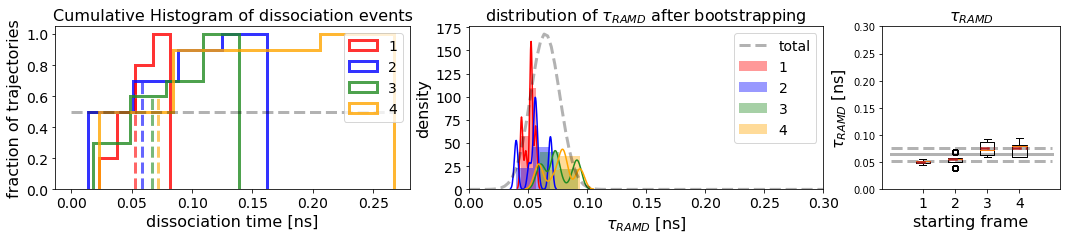

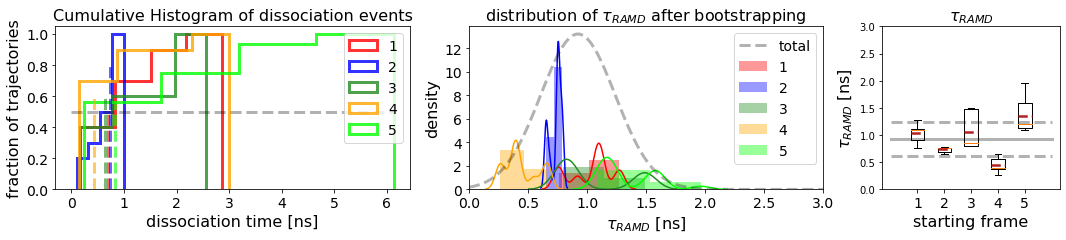

()

In [22]:

def Plot_tauRAMD_workflow(t,tr,lims):

    color = ['r','b','forestgreen','orange','lime','m','teal','c','yellow','goldenrod','olive','tomato','salmon','seagreen']
    fig = plt.figure(figsize=(18, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 1],wspace=0.2) 
    ax1 = plt.subplot(gs[0])
    for i,it in enumerate(t):
        ax1.hist(t[i], color=color[i], bins=4,normed=True,cumulative= True, lw=3,alpha=0.8,label=i+1,histtype="step")
        H,X1 = np.histogram(t[i],normed=True)
        dx = X1[1] - X1[0]
        F1 = np.cumsum(H)*dx
        plt.plot([X1[np.argwhere(F1>0.5)][0],X1[np.argwhere(F1>0.5)][0]], [0, F1[np.argwhere(F1>0.5)][0]], 'k--', lw=3,color =color[i],alpha=0.6)
    ax1.set_title('Cumulative Histogram of dissociation events',fontsize=16)
    ax1.set_ylabel('fraction of trajectories',fontsize=16)
    ax1.set_xlabel('dissociation time [ns]',fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.plot([0,np.max(np.max(np.asarray(t)))], [0.5, 0.5], 'k--', lw=3,color="k",alpha=0.3)


    ax2 = plt.subplot(gs[1])
    x = np.linspace(start=lims[0],stop=lims[1],num=100)
    for i,(d,b) in enumerate(zip(tr.ramd.replicas_distr,tr.ramd.length)):
        sns.distplot(d, kde=True, hist = True, norm_hist = True, bins = 2, color =color[i],label=tr.ramd.names[i][-1:], ax = ax2);   
        ymin, ymax = ax2.get_ylim()

    gauss = np.exp(-np.power((x - tr.ramd.tau)/tr.ramd.tau_SD, 2.)/2.)
    ax2.plot(x,ymax*gauss/max(gauss), 'k--', label='total', linewidth=3,alpha=0.3)
    plt.legend(fontsize=14) 
    ax2.set_xlim(lims)
    ax2.set_title('distribution of '+r'$\tau_{RAMD} $'+' after bootstrapping',fontsize=16)
    ax2.set_ylabel('density',fontsize=16)
    ax2.set_xlabel(r'$\tau_{RAMD} $ [ns]',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    ax3 = plt.subplot(gs[2])
    ax3.set_ylim([0,min(10*tr.ramd.tau,lims[1])])
    meanpointprops = dict(linestyle='--', linewidth=2.5, color='firebrick')
    ax3.boxplot(tr.ramd.replicas_distr,labels=tr.ramd.names,showmeans=True, meanline=True,meanprops=meanpointprops) 
    ax3.plot([0,len(tr.ramd.names)+1], [tr.ramd.tau,tr.ramd.tau], 'k-', lw=3,alpha=0.3)
    ax3.plot([0,len(tr.ramd.names)+1], [tr.ramd.tau-tr.ramd.tau_SD,tr.ramd.tau-tr.ramd.tau_SD], 'k--', lw=3,alpha=0.3)
    ax3.plot([0,len(tr.ramd.names)+1], [tr.ramd.tau+tr.ramd.tau_SD,tr.ramd.tau+tr.ramd.tau_SD], 'k--', lw=3,alpha=0.3)
    ax3.set_title(r'$\tau_{RAMD} $',fontsize=16)
    ax3.set_xlabel('starting frame',fontsize=16)
    ax3.set_ylabel(r'$\tau_{RAMD} $ [ns]',fontsize=16)
    plt.xticks(range(1,len(tr.ramd.names)+1),range(1,len(tr.ramd.names)+1), fontsize=14)

    plt.show()
    return()


t = []
#t.append([0.124, 0.189, 0.334, 0.227, 0.192, 0.048, 0.4150, 0.028, 0.058, 0.067, 0.213])
#t.append([0.162, 0.294, 0.856, 0.103000, 0.296, 0.231, 0.311, 0.65, 0.243, 1.434])
#t.append([1.212, 0.395, 0.301, 0.401, 1.467, 0.932, 0.848, 0.513, 0.275, 0.43, 0.733, 0.244, 0.186, 0.324])
#t.append([0.1440, 0.2060, 0.213, 0.084, 0.16, 0.105, 0.1440, 0.032, 0.076, 0.166])
tr = tr_FAK[np.argwhere(np.asarray(tr_FAK_name) == '2393980-A-loop-Hel')[0][0]]
for t_raw in tr.ramd.replicas_distr_raw:
    t.append(t_raw)
lims= [0,0.3]

Plot_tauRAMD_workflow(t,tr,lims)

t = []
#t.append([4.155, 2.214, 0.747, 3.225, 3.221, 4.188, 5.692, 9.864, 5.175, 6.037])
#t.append([3.74, 3.435, 0.757, 4.018, 0.95800, 0.988, 9.578, 1.642000, 9.666, 6.075])
#t.append([12.8, 2.95, 4.974, 1.096, 2.562, 0.916, 1.583, 12.805, 3.394, 4.621])
#t.append([4.355, 2.981, 9.267, 2.358, 5.947, 1.064, 5.898, 0.506, 2.53400, 0.808])
tr = tr_FAK[np.argwhere(np.asarray(tr_FAK_name) == '2529902')[0][0]]
for t_raw in tr.ramd.replicas_distr_raw:
    t.append(t_raw)
lims= [0,3]

Plot_tauRAMD_workflow(t,tr,lims)

# 5. Testing  IFP function 

## HSP90 structure (prepared for MD simulations)

In [ ]:
###########################
#  first we will use the last snapshot from one equilibration trajectory to check IFP found
###############################

ref= "/hits/fast/mcm/kokhda/TMP/ref.pdb"
trj= "/hits/fast/mcm/kokhda/TMP/amber2namd.dcd"
ligand_pdb = "/hits/fast/mcm/kokhda/TMP/INH.pdb"
ligand_mol2 = "/hits/fast/mcm/kokhda/TMP/moe.mol2"

ff=open(ligand_pdb,"r")
lines = ff.readlines()
ff.close()

list_labels = []
for line in lines:
    if line.split()[0] == 'ATOM': list_labels.append(line.split()[2]) 
print(list_labels)        
        
mol = Chem.rdmolfiles.MolFromMol2File(ligand_mol2,removeHs=False)   
ligand_2D =Chem.MolFromSmiles(Chem.MolToSmiles(mol))
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
feats = factory.GetFeaturesForMol(mol)
properties_list = {}
for f in feats:
    prop = f.GetFamily()  #  get property name
    at_indx  = list(f.GetAtomIds())  # get atom index
    if prop not in properties_list.keys():
        properties_list[prop]=[]
    if(len(at_indx) > 0):
        for l in at_indx: properties_list[prop].append(list_labels[l])
    else: properties_list[prop].append(list_labels[at_indx[0]])
print(properties_list)
property_list = properties_list
u = mda.Universe(ref)
ref = mda.Universe(ref)
Rgr0 = ref.select_atoms("protein").radius_of_gyration()

u.load_new(trj)  
u.trajectory[-1]
Rgr = pbc(u,Rgr0)
rmsd = superimpose_traj(ref,u,["protein","resname INH"])
print("RMSD (protein , ligand):",rmsd)
u_length = len(u.trajectory)
system_reduced = u.select_atoms("all")    
u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=-2,stop=-1,step=2).results,format=MemoryReader)

df_prop,df_HB,df_WB = IFP(u_mem,"INH",property_list,WB_analysis=True,RE=False,Lipids= [])
df_prop_complete = table_combine(df_HB,df_WB,df_prop,"INH")

In [ ]:
print("\nProtein RESIDUES that interact with the Ligand:")
print(df_prop_complete.columns.tolist())
print("\nRESIDUES participating in the Prot.-Wat-Lig H-bond network:")
df_WB

In [ ]:
df_HB

In [ ]:
#################################################
# visual check : let us show all residues participating in protein-ligand water bridges and protein-ligand H-bonds
################################################

view = nv.NGLWidget()
protein = u.select_atoms('all')
w=nv.show_mdanalysis(protein)
w.add_licorice("35 36  77 81 168 208 265 269 271 ")
w

In [ ]:
#################################################
# visual check : let us show all residues participating in protein-ligand contacts 
################################################

view = nv.NGLWidget()
protein = u.select_atoms('all')
w=nv.show_mdanalysis(protein)
#we will select only Aromatic interactions (one can also select only HD , HA, IP, IN, WB, HA)
resi = ""
for ifp in df_prop_complete.columns.tolist():
    if(ifp[:2] == "AR"): resi += str(ifp[6:])+ " "
print(resi)
w.add_licorice(resi)
w

In [ ]:
#############################
# Now in a complete trajectory
########################
u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=0,stop=-1,step=50).results,format=MemoryReader)

save_pdb = False

for i in range(0,len(u_mem.trajectory),1):
    u_mem.trajectory[i]  
    u_mem.dimensions = u.dimensions
    Rgr = pbc(u_mem,Rgr0)
    rmsd = superimpose_traj(ref,u_mem,["protein","resname INH"])
    print(i,"RMSD (protein , ligand):",rmsd,"traj length:",u_length)
    if save_pdb == True:
        all_write = u.select_atoms("all")
        all_write.write("/hits/fast/mcm/kokhda/TMP/"+"/namd_protein-"+str(i)+".pdb")


df_prop,df_HB,df_WB = IFP(u_mem,"INH",property_list,WB_analysis=True,RE=False,Lipids= [])
df_prop_complete = table_combine(df_HB,df_WB,df_prop,"INH")
Plot_IFP(df_prop_complete,contact_collection=None)

In [ ]:
df_WB[df_WB.sele2_resid == 75]
df_WB[df_WB.sele2_resid == 271]

In [ ]:
#################################################
# visual check : hydrogen bonds and water bridges
################################################

view = nv.NGLWidget()
protein = u.select_atoms('all')
w=nv.show_mdanalysis(protein)
w.add_licorice("32 35 36 75 77 81 168 170 271 269")
w

## Now FAK trajectory- look for ARG - INH water bridges

In [ ]:
# check water analysis
tr = tr_FAK[np.argwhere(np.array(tr_FAK_name) == '1ucyh')[0][0]]
traj = tr.namd.repl_traj[0]

ref = mda.Universe(tr.PRJ_DIR+tr.pdb)
Rgr0 = ref.select_atoms("protein").radius_of_gyration()
u = mda.Universe(tr.PRJ_DIR+tr.pdb)
u.load_new(traj)  
u_length = len(u.trajectory)

print(tr.ligand.property_list)
save_pdb = False  # save pdb files for all frames analyzed

for i in range(0,len(u.trajectory),10):
    u.trajectory[i]
    Rgr = pbc(u,Rgr0)
    rmsd = superimpose_traj(ref,u,["protein","resname INH"])
    print(i,"RMSD (protein , ligand):",rmsd,"traj length:",u_length)
    if save_pdb == True:
        all_write = u.select_atoms("all")
        all_write.write(tr.PRJ_DIR+"/namd1_protein-"+str(i)+".pdb")
    
system_reduced = u.select_atoms("all")    
u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=0,stop=-100,step=1).results,format=MemoryReader)
df_prop,df_HB,df_WB = IFP(u_mem,"INH",tr.ligand.property_list,WB_analysis=True,RE=False,Lipids= [])
df_prop_complete = table_combine(df_HB,df_WB,df_prop,"INH",tr.namd.contact_collection)


In [ ]:
Plot_IFP(df_prop_complete,contact_collection=None)

In [ ]:
ref = mda.Universe(tr.PRJ_DIR+tr.pdb)
u = mda.Universe(tr.PRJ_DIR+tr.pdb)
u.load_new(traj) 
for i in range(0,len(u.trajectory),10):
    u.trajectory[i]
    Rgr = pbc(u,Rgr0)
    rmsd = superimpose_traj(ref,u,["protein","resname INH"])
    
    
property_list = tr.ligand.property_list
print(property_list)
hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_DONORS['CHARMM27']
hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['CHARMM27']
hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF']+tuple(set("O"))        
if "Donor" in set(property_list):
        donor_line = tuple(set(property_list["Donor"]))
        hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF']+donor_line
if "Acceptor" in set(property_list):      
        acceptor_line = tuple(set(property_list["Acceptor"]))
        hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['OtherFF']+acceptor_line

u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=0,stop=-100,step=1).results,format=MemoryReader)
w = hb.WaterBridgeAnalysis(u, selection1  = 'resname INH', selection2  = 'protein',water_selection=" resname WAT HOH SOL ",  distance=3.5, angle=110, forcefield='OtherFF',order=3)
w.run()
w.generate_table()
df_WB = pd.DataFrame.from_records(w.table)
df_WB

In [ ]:
np.unique(df_WB.sele2_resnm.values)

In [ ]:
# get a list of INH-WAT (sele1 - sele2)
df_WB_INH = df_WB[(df_WB.sele1_resnm.isin(["INH"]) & df_WB.sele2_resnm.isin(["WAT"]))]
# get a list of WAT-Prot (sele1 - sele2)
df_WB_Prot = df_WB[(~(df_WB.sele2_resnm.isin(["INH","WAT"])) & (df_WB.sele1_resnm.isin(["WAT"])))]
df_WB_WAT = df_WB[((df_WB.sele2_resnm == "WAT") & (df_WB.sele1_resnm == "WAT"))]

for t in df_WB.time.unique().tolist():
    df_WB_t = df_WB[df_WB.time == t]
    df_WB_WAT_t = df_WB_WAT[df_WB_WAT.time == t]
    df_WB_Prot_t = df_WB_Prot[df_WB_Prot.time == t]
    df_WB_INH_t = df_WB_INH[df_WB_INH.time == t]
    if ((not df_WB_Prot_t.empty) and (not df_WB_INH_t.empty)):
        common_WAT = np.intersect1d(df_WB_INH_t.sele2_resid.values,df_WB_Prot_t.sele1_resid.values)
        print(int(t),"---> common WAT --->",common_WAT,"Prot: ",np.unique(df_WB_Prot_t.sele2_resid.values))
        for w in common_WAT:
            p = df_WB_Prot_t[df_WB_Prot_t.sele1_resid == w].sele2_resnm.values
            i = df_WB_INH_t[df_WB_INH_t.sele2_resid == w].sele1_resnm.values
            print("                                         check: ",i,p)
#        print(df_WB_t[~((df_WB.sele1_resnm == "INH") & (df_WB.sele2_resnm != "WAT"))])
        


In [ ]:

hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_DONORS['CHARMM27']
hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['CHARMM27']
hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF']+tuple(set("O"))        
if "Donor" in set(property_list):
        donor_line = tuple(set(property_list["Donor"]))
        hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF']+donor_line
if "Acceptor" in set(property_list):      
        acceptor_line = tuple(set(property_list["Acceptor"]))
        hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['OtherFF']+acceptor_line

        
w = hb.WaterBridgeAnalysis(u, 'resname INH ', ' not resname WAT HOH SOL ',water_selection=" resname WAT HOH SOL ",  distance=3.5, angle=110, forcefield='OtherFF',output_format="donor_acceptor")
w.run()
w.generate_table()
df_WB = pd.DataFrame.from_records(w.table)

df_WB

## Generation of IFPs for Equilibration trajectories (FAK and PYK2)

In [ ]:
# AUXI: 1st beta-strand; C-helix; A-loop
    
for i,(tr,name) in enumerate(zip(tr_PYK,tr_PYK_name)):
#    if (name.find("2216855-PROT-conf2") < 0): continue
    print(i," =======================",tr.PRJ_DIR,"=============================")
    auxi_selection = ["((resid 7:20) and (not type H))","((resid 47:64) and (not type H))","((resid 150:156) and (not type H))"]
    try:
        tr.analysis_all_namd(WB_analysis = True,step_analysis=1,start_analysis = -400,RE = True,auxi_selection =auxi_selection)
        tr.namd.IFP_save(tr.PRJ_DIR+tr_PYK_name[i]+"-P-NAMD.pkl")
    except:
        pass



In [ ]:


for i,(tr,name) in enumerate(zip(tr_FAK,tr_FAK_name)):
    print(i," =======================",tr.PRJ_DIR,"=============================")
    auxi_selection = ["((resid 8:21) and (not type H))","((resid 48:65) and (not type H))","((resid 151:157) and (not type H))"]
    try:
        tr.analysis_all_namd(WB_analysis = True,step_analysis=1,start_analysis = -400,RE = True,auxi_selection =auxi_selection)
        tr.namd.IFP_save(tr.PRJ_DIR+tr_FAK_name[i]+"-F-NAMD.pkl")
    except:
        pass



In [ ]:
tr_FAK[12].namd.traj[0].df_properties['HD_ARG13'].mean()

In [ ]:
ligand2save = '1ucyh'
tr = tr_FAK[np.argwhere(np.asarray(tr_FAK_name) == ligand2save)[0][0]]
tr.analysis_all_namd(WB_analysis = True,step_analysis=5,start_analysis = -500,RE = True,auxi_selection = ["((resid 154:173) and not (type H))"])
tr.namd.IFP_save(tr.PRJ_DIR+ligand2save+"-F-namd_com.pkl")


In [ ]:
ligand2save = '1ucyh_3fzr'
tr = tr_PYK[np.argwhere(np.asarray(tr_PYK_name) == ligand2save)[0][0]]
tr.analysis_all_namd(WB_analysis = True,step_analysis=5,start_analysis = -500,RE = True,auxi_selection = ["((resid 154:173) and not (type H))"])
tr.namd.IFP_save(tr.PRJ_DIR+ligand2save+"-P-namd_com.pkl")


In [ ]:
tr.ligand.ligands_names

## 4. Analysis of all RAMD trajectories for all FAK compound

In [ ]:
plt.plot(tr_FAK[0].namd.traj[0].rmsd_auxi[0])
plt.plot(tr_FAK[0].namd.traj[1].rmsd_auxi[0])


In [ ]:
length,start,rmsd_prot,rmsd_lig, rmsd_auxi,Rgr_prot, Rgr_lig,com_lig,df_prop,df_HB,df_WB= \
tr_FAK[0].analysis_traj(tr_FAK[0].namd.repl_traj[0],WB_analysis = True,step_analysis=5,start_analysis = -500,RE = True,Lipids=[],auxi_selection = ["((resid 154:173) and not (type H))"])


In [ ]:
plt.plot(rmsd_auxi[0])

In [ ]:
length,start,rmsd_prot,rmsd_lig, rmsd_auxi,Rgr_prot, Rgr_lig,com_lig,df_prop,df_HB,df_WB= \
tr_FAK[0].analysis_traj(tr_FAK[0].namd.repl_traj[1],WB_analysis = True,step_analysis=5,start_analysis = -500,RE = True,Lipids=[],auxi_selection = ["((resid 154:173) and not (type H))"])
plt.plot(rmsd_auxi[0])

In [ ]:
length,start,rmsd_prot,rmsd_lig, rmsd_auxi,Rgr_prot, Rgr_lig,com_lig,df_prop,df_HB,df_WB= \
tr_FAK[0].analysis_traj(tr_FAK[0].namd.repl_traj[2],WB_analysis = True,step_analysis=5,start_analysis = -500,RE = True,Lipids=[],auxi_selection = ["((resid 154:173) and not (type H))"])
plt.plot(rmsd_auxi[0])

In [ ]:
length,start,rmsd_prot,rmsd_lig, rmsd_auxi,Rgr_prot, Rgr_lig,com_lig,df_prop,df_HB,df_WB= \
tr_FAK[0].analysis_traj(tr_FAK[0].namd.repl_traj[5],WB_analysis = True,step_analysis=5,start_analysis = -500,RE = True,Lipids=[],auxi_selection = ["((resid 154:173) and not (type H))"])
plt.plot(rmsd_auxi[0])

## 5. Analysis of all NAMD trajectories for a selected FAK compound

In [ ]:
# visualize selected compound
tr = tr_FAK[np.argwhere(np.asarray(tr_FAK_name) == '2358758')[0][0]]
tr.ligand.ligand_2D


In [ ]:
#plot tauRAMD analysis for different replicas for a particular compound
Plot_RAMD(tr)

In [ ]:
# make analysis
tr.analysis_all_namd(step_analysis=2, start_analysis=-100)

In [ ]:
#plot results of the analysis
for j,nmd in enumerate(tr.namd.names):
    print(nmd)
    Plot_IFP(tr.namd.df_properties[j])
    Plot_traj(tr.namd.rmsd_prot[j],tr.namd.rmsd_lig[j],tr.namd.Rgr_prot[j],tr.namd.Rgr_lig[j],nmd) 
#tr.namd.contact_collection

In [ ]:
tr.compare_all_namd()


## testing new water bridges procedure in MDAnalysis

In [ ]:
ref= "/hits/fast/mcm/kokhda/TMP/ref.pdb"
trj= "/hits/fast/mcm/kokhda/TMP/amber2namd.dcd"
ligand_pdb = "/hits/fast/mcm/kokhda/TMP/INH.pdb"
ligand_mol2 = "/hits/fast/mcm/kokhda/TMP/moe.mol2"


ff=open(ligand_pdb,"r")
lines = ff.readlines()
ff.close()

list_labels = []
for line in lines:
    if line.split()[0] == 'ATOM': list_labels.append(line.split()[2]) 
print(list_labels)        
        
mol = Chem.rdmolfiles.MolFromMol2File(ligand_mol2,removeHs=False)   
ligand_2D =Chem.MolFromSmiles(Chem.MolToSmiles(mol))
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
feats = factory.GetFeaturesForMol(mol)
properties_list = {}
for f in feats:
    prop = f.GetFamily()  #  get property name
    at_indx  = list(f.GetAtomIds())  # get atom index
    if prop not in properties_list.keys():
        properties_list[prop]=[]
    if(len(at_indx) > 0):
        for l in at_indx: properties_list[prop].append(list_labels[l])
    else: properties_list[prop].append(list_labels[at_indx[0]])
print(properties_list)
property_list = properties_list
u = mda.Universe(ref)


hb.HydrogenBondAnalysis.DEFAULT_DONORS['OtherFF'] = hb.HydrogenBondAnalysis.DEFAULT_DONORS['CHARMM27']
hb.HydrogenBondAnalysis.DEFAULT_ACCEPTORS['OtherFF'] = hb.HydrogenBondAnalysis.DEFAULT_ACCEPTORS['CHARMM27']
hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_DONORS['CHARMM27']
hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['CHARMM27']
if "Donor" in set(property_list):
        donor_line = tuple(set(property_list["Donor"]))
        hb.HydrogenBondAnalysis.DEFAULT_DONORS['OtherFF'] = hb.HydrogenBondAnalysis.DEFAULT_DONORS['OtherFF']+donor_line
        hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF']+donor_line
if "Acceptor" in set(property_list):      
        acceptor_line = tuple(set(property_list["Acceptor"]))
        hb.HydrogenBondAnalysis.DEFAULT_ACCEPTORS['OtherFF'] = hb.HydrogenBondAnalysis.DEFAULT_ACCEPTORS['OtherFF']+acceptor_line
        hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_ACCEPTORS['OtherFF']+acceptor_line

        
hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF'] = hb.WaterBridgeAnalysis.DEFAULT_DONORS['OtherFF']+tuple(set("O"))        
w = hb.WaterBridgeAnalysis(u, 'resname INH ', ' not resname WAT HOH SOL ',water_selection=" resname WAT HOH SOL ",  distance=3.5, angle=110, forcefield='OtherFF',order=3)
w.run()
w.generate_table()
df_WB = pd.DataFrame.from_records(w.table)

df_WB

In [ ]:
df_WB_INH = df_WB[df_WB.sele1_resnm == "INH"]
df_WB_INH_WAT = df_WB[df_WB.sele2_resnm == "WAT"]
df_WB_INH_WAT.sele2_resid.values
df_WB[df_WB.sele1_resid.isin(df_WB_INH_WAT.sele2_resid.values)].

In [ ]:
import nglview as nv
view = nv.NGLWidget()


protein = u.select_atoms('all')
w=nv.show_mdanalysis(protein)
w.add_licorice("WAT")
w


## 6.  Structure preparation (IGF1R) - generation of Gamess input files

In [ ]:
# generate Gamess input files
#struct = complex_structure(PRJ_DIR = "/hits/fast/mcm/kokhda/IGF1R/buergete/igfr/JinLigands/AZ14107561", PRJ_Name = "lig_ND7")
from SetUp.setup_membrane_simulations_AMBER import input_RESP_with_GAMESS
os.chdir("/hits/fast/mcm/kokhda/IGF1R/buergete/igfr/JinLigands/AZ14107561/")
input_RESP_with_GAMESS("ligand_ND7.pdb")
os.chdir("/hits/fast/mcm/kokhda/IGF1R/buergete/igfr/JinLigands/AZ14124588/")
input_RESP_with_GAMESS("ligand_KG9.pdb")
os.chdir("/hits/fast/mcm/kokhda/IGF1R/buergete/igfr/JinLigands/AZ14111672/")
input_RESP_with_GAMESS("ligand_ND13.pdb")
os.chdir("/hits/fast/mcm/kokhda/IGF1R/buergete/igfr/JinLigands/AZ14111965/")
input_RESP_with_GAMESS("ligand_ND14.pdb")

In [ ]:
struct = complex_structure(PRJ_DIR = "/hits/fast/mcm/kokhda/M2-Virus/AK59_DMPC", PRJ_Name = "AK59_DMPC")

struct.charmm_gui(self,charmm_gui_file = "step5_assembly.pdb") 

superimpose_prot_lig(self,protein_pdb="AK61_DMPC_Udorn.pdb",ligand_pdb="AK61_DMPC.pdb")


In [ ]:
# this is a working folder
PRJ_DIR="/hits/fast/mcm/kokhda/M2-Virus/AK61_DMPC/"
if PRJ_DIR[:-1] != "/": PRJ_DIR = PRJ_DIR+"/"

## System preparation using Charmm-GUI input file (generally step5_assembly.pdb)
    Here a pdb file  prepared by CharmmGUI will be splitted into separate components: protein, membrane, water, ions
    Then disulfate bridges will be found and renamed according to the AMBER schema
    Finally lipids will be re-constracted by charmmlipid2amber.py
    
    Ligand is not considered at this step

In [ ]:
#############################
#    System (no ligand)
#############################
#--- split complex generated by Charmm-GUI
from SetUp.setup_membrane_simulations_AMBER import Replace_CYS_CYX , split_charmm_gui

os.chdir(PRJ_DIR)
box = split_charmm_gui("step5_assembly.pdb",H=False, TER=True)
print(box)
#---- find sulfur bridges  and replace CYS by CYX
cyx = Replace_CYS_CYX("step5_assembly_Protein.pdb")
#amber=os.environ['AMBERHOME']  # general check if amber tools are  available
#if len(amber) > 2:
os.system("charmmlipid2amber.py -i step5_assembly_Mem.pdb  -o  step5_assembly_Mem_Amber.pdb")

In [ ]:
####################################
#  Superimposition of protein (and ligand) with a protein prepared by Charmm-Gui
####################################
from SetUp.setup_membrane_simulations_AMBER import protein_ligand_align, rename_H, protein_ligand_superimpose
os.chdir(PRJ_DIR)
protein_pdb = "AK61_DMPC_Udorn.pdb"
new_protein_pdb = "AK61_DMPC_Udorn_aligned.pdb"
reference_file  = "step5_assembly_Protein.pdb"

ligand_pdb = "AK61_DMPC.pdb"   # check repeating atoms!!!!!!

new_ligand_pdb = "AK61_DMPC_aligned.pdb"

protein_ligand_superimpose(reference_file,protein_pdb,new_protein_pdb,ligand_pdb=ligand_pdb,new_ligand_pdb = new_ligand_pdb)

In [ ]:
###############################
#   Ligand 
###############################
from SetUp.setup_membrane_simulations_AMBER import input_RESP_with_GAMESS, replace_charges, compute_charge
#ligand_pdb = x + "AK61_DMPC_aligned.pdb"
#ligand_H_pdb = ligand_pdb[:-4]+"_H.pdb"

ligand_H_pdb = new_ligand_pdb
ligand_H_mol2 =ligand_H_pdb[:-4]+"_template.mol2"
new_ligand_H_mol2 =ligand_pdb[:-4]+"_new.mol2"
charges = "charges.chg"

#----------   add hydrogens to ligand -----------------
#os.system("obabel "+ligand_pdb + " -O " + ligand_H_pdb + " -h") 

#------------  generate GAMESS input -------------------
#input_RESP_with_GAMESS(ligand_pdb)

#---  generate charges using openbabel  (mol2 format different from AMBER)
#os.system("obabel  " + ligand_H_pdb +" -O " + ligand_H_mol2 + " --partialcharge ")

#if(ligand_H_pdb[:-4]+"_energy.dat"):
#    charge = compute_charge(ligand_H_mol2)

#---- replace charges 
os.system(" antechamber -i "+ligand_H_pdb+" -fi pdb -o "+ligand_H_mol2+" -fo mol2 -c bcc -s 2 -nc 1 -m 1; \
parmchk -i  " + ligand_H_mol2 + " -f mol2 -o INH.frcmod")

In [ ]:
replace_charges(ligand_H_mol2,new_ligand_H_mol2,new_charges_mol2="",charges=charges)
os.system(" rm tmp.mol2; ln -s "+new_ligand_H_mol2+" tmp.mol2")